#Colab Setup

In [ ]:
\
# Colab Setup
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# After downloading the shared starting point folder as a Zip
# Unzip it and re-upload it to a location on your GDrive

# This command copies the contents from the folder you uploaded to GDrive, to the colab working dir
!cp -r /content/drive/MyDrive/RI/ProjectoRI2020 /content

# Add working dir to the sys path, so that we can find the aux python files when running the Notebook
import sys
if not 'ProjectoRI2020' in sys.path:
  sys.path += ['/content/ProjectoRI2020']

# Finally install required dependencies to run the notebook
!pip install elasticsearch
!pip install bert-serving-client
!pip install transformers
!pip install tqdm
!pip install spacy
!python -m spacy download en_core_web_sm
%tensorflow_version 2.x
!pip install t5==0.5.0


!rm -rf /content/t5-canard
# !cp -r /content/drive/MyDrive/Work/PhD/TAships/RI2020/t5-canard.zip/ /content/t5-canard.zip
!cp -r /content/drive/MyDrive/RI/ProjectoRI2020/t5-canard.zip /content/t5-canard.zip
!unzip /content/t5-canard.zip


Mounted at /content/drive
     |████████████████████████████████| 327kB 9.0MB/s 
     |████████████████████████████████| 1.5MB 7.9MB/s 
     |████████████████████████████████| 2.9MB 25.4MB/s 
     |████████████████████████████████| 890kB 53.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=abec13248cdd6b70a697b6e1afb103e65ffd8c124d41d54c4c69271c6a242660
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 143kB 7.5MB/s 
     |████████████████████████████████| 3.7MB 13.3MB/s 
     |████████████████████████████████| 1.1MB 52.7MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 368kB 53.4MB/s 
     |████████████████████████████████| 3.4MB 54.4MB/s 
Archive:  /content/t5

#Imports

In [ ]:
import numpy as np
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertTokenizerFast, BertModel
import torch
import TRECCASTeval as trec
import numpy as np
import pandas as pd
import ElasticSearchSimpleAPI as es
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#import Graphics 
import pprint
import spacy
import tensorflow as tf
import tensorflow_text
from tqdm import tqdm


In [ ]:
elastic = es.ESSimpleAPI()
test_bed = trec.ConvSearchEvaluation()

#BERT Setup


In [ ]:
bert_model_name = 'nboost/pt-bert-base-uncased-msmarco'
CLS_token = "[CLS]"
SEP_token = "[SEP]"
tokenizer = BertTokenizerFast.from_pretrained(bert_model_name)
device = torch.device("cuda")
model = BertModel.from_pretrained(bert_model_name, return_dict=True)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
def convert_to_bert_input(sentences, max_seq_length, tokenizer, add_cls, return_tensors="pt"):

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0   0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). 
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as as the "sentence vector".
    
    # Tokenize both sentences
    sentences_tokens = [tokenizer.tokenize(s + SEP_token) for s in sentences]
    
    # Combine sentences tokens on a single list
    tokens = sum(sentences_tokens, [])
    
    if add_cls:
        tokens = [CLS_token] + tokens

    # Create Token type ids tensors
    token_type_ids = [[i]*len(s) for i, s in enumerate(sentences_tokens)] # Acount for the SEP token we've just added
    token_type_ids = [0] + sum(token_type_ids, []) # CLS + The whole token_type_ids flattened

    # Remove tokens if max_seq_length is exceeded
    # Account for [CLS] and [SEP] with "- 3"
    if len(tokens) > max_seq_length - 3:
        tokens = tokens[:max_seq_length - 4] + [tokens[-1]] # keep SEP token
        token_type_ids = token_type_ids[:max_seq_length - 3]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
     # Create Attention mask tensor -> Which tokens should BERT consider
    attention_mask = [1]*len(tokens)
    
    if return_tensors == "pt":
        input_ids = torch.tensor([input_ids], dtype=torch.long)
        token_type_ids = torch.tensor([token_type_ids], dtype=torch.long)
        attention_mask = torch.tensor([attention_mask], dtype=torch.long)
    
    data = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask
    }

    return data

# Query Rewritting Setup

Classe Query Rewritter

In [ ]:
class QueryRewriterT5:
  def __init__(self, model_path="/content/t5-canard"):
    """
      Loads T5 model for prediction
      Returns the model
    """
    if tf.executing_eagerly():
        print("Loading SavedModel in eager mode.")
        imported = tf.saved_model.load(model_path, ["serve"])
        self.t5_model = lambda x: imported.signatures['serving_default'](tf.constant(x))['outputs'].numpy()
    else:
        print("Loading SavedModel in tf 1.x graph mode.")
        tf.compat.v1.reset_default_graph()
        sess = tf.compat.v1.Session()
        meta_graph_def = tf.compat.v1.saved_model.load(sess, ["serve"], model_path)
        signature_def = meta_graph_def.signature_def["serving_default"]
        self.t5_model = lambda x: sess.run(
            fetches=signature_def.outputs["outputs"].name,
            feed_dict={signature_def.inputs["input"].name: x}
        )
  
  """
    query: str - the query string to be rewritten using T5
    ctx_list: list - A list of strings containing the turns or text to give context to T5
    Returns a string with the rewritten query
  """
  def rewrite_query_with_T5(self, _curr_query, _ctx_list):
    _t5_query = '{} [CTX] '.format(_curr_query) + ' [TURN] '.join(_ctx_list)
    print("Query and context: {}".format(_t5_query))
    return self.t5_model([_t5_query])[0].decode('utf-8')

  """
    queries_list: list - A list of strings containing the raw utterances ordered from first to last
    Returns a list of strings with the rewritten queries
  """
  def rewrite_dialog_with_T5(self, _queries_list):
    _rewritten_queries_list=[]
    for i in range(len(_queries_list)):
      _current_query = _queries_list[i]
      _rewritten_query = self.rewrite_query_with_T5(_current_query, _queries_list[:i])
      print("Rewritten query: {}\n".format(_rewritten_query))
      _rewritten_queries_list.append(_rewritten_query)
    return _rewritten_queries_list

Obetio Query Rewritter

In [ ]:
rewriter = QueryRewriterT5('/content/t5-canard')

Loading SavedModel in eager mode.


#Utterances Joined

Treino

In [ ]:
#utterances de treino
utterances_joined_1_train = {}
for topic in test_bed.train_topics:
  utterances_joined_1_train[topic['number']] = []
  utterances = topic['turn'][0]['raw_utterance']
  for turn in topic['turn']:
    #utterances = ' '.join([turn['raw_utterance'], utterances])
    utterances_joined_1_train[topic['number']].append(' '.join([turn['raw_utterance'], utterances]))

pprint.pprint(utterances_joined_1_train)

{1: ["What is a physician's assistant? What is a physician's assistant?",
     'What are the educational requirements required to become one? What is a '
     "physician's assistant?",
     "What does it cost? What is a physician's assistant?",
     "What's the average starting salary in the UK? What is a physician's "
     'assistant?',
     "What about in the US? What is a physician's assistant?",
     'What school subjects are needed to become a registered nurse? What is a '
     "physician's assistant?",
     "What is the PA average salary vs an RN? What is a physician's assistant?",
     'What the difference between a PA and a nurse practitioner? What is a '
     "physician's assistant?",
     "Do NPs or PAs make more? What is a physician's assistant?",
     "Is a PA above a NP? What is a physician's assistant?",
     "What is the fastest way to become a NP? What is a physician's assistant?",
     'How much longer does it take to become a doctor after being an NP? What '
     "is 

Teste

In [ ]:
#utterances de teste
utterances_joined_1_test = {}
for topic in test_bed.test_topics:
  utterances_joined_1_test[topic['number']] = []
  utterances = topic['turn'][0]['raw_utterance']
  for turn in topic['turn']:
    #utterances = ' '.join([turn['raw_utterance'], utterances])
    utterances_joined_1_test[topic['number']].append(' '.join([turn['raw_utterance'], utterances]))

pprint.pprint(utterances_joined_1_test)

{31: ['What is throat cancer? What is throat cancer?',
      'Is it treatable? What is throat cancer?',
      'Tell me about lung cancer. What is throat cancer?',
      'What are its symptoms?  What is throat cancer?',
      'Can it spread to the throat? What is throat cancer?',
      'What causes throat cancer? What is throat cancer?',
      'What is the first sign of it? What is throat cancer?',
      'Is it the same as esophageal cancer? What is throat cancer?',
      "What's the difference in their symptoms? What is throat cancer?"],
 32: ['What are the different types of sharks? What are the different types of '
      'sharks?',
      'Are sharks endangered?  If so, which species? What are the different '
      'types of sharks?',
      'Tell me more about tiger sharks. What are the different types of '
      'sharks?',
      'What is the largest ever to have lived on Earth? What are the different '
      'types of sharks?',
      "What's the biggest ever caught? What are the diff

#Query Rewritting de Uterancias + Entidades



Treino

In [ ]:
utterances_entities_t5_train = {}
for topic in test_bed.train_topics:
    utterances_topic = [t['raw_utterance'].strip() for t in topic['turn']]
    rewritten_utterances = rewriter.rewrite_dialog_with_T5(utterances_topic)
    utterances_entities_t5_train[topic['number']] = rewritten_utterances
pprint.pprint(utterances_entities_t5_train)

Query and context: What is a physician's assistant? [CTX] 
Rewritten query: What is a physician's assistant?

Query and context: What are the educational requirements required to become one? [CTX] What is a physician's assistant?
Rewritten query: What are the educational requirements required to become a physician's assistant?

Query and context: What does it cost? [CTX] What is a physician's assistant? [TURN] What are the educational requirements required to become one?
Rewritten query: What educational requirements are required in becoming a physician's assistant?

Query and context: What's the average starting salary in the UK? [CTX] What is a physician's assistant? [TURN] What are the educational requirements required to become one? [TURN] What does it cost?
Rewritten query: What is the average starting salary of a physician's assistant in the UK?

Query and context: What about in the US? [CTX] What is a physician's assistant? [TURN] What are the educational requirements required t

Teste

In [ ]:
utterances_entities_t5_test = {}
for topic in test_bed.test_topics:
    utterances_topic = [t['raw_utterance'].strip() for t in topic['turn']]
    rewritten_utterances = rewriter.rewrite_dialog_with_T5(utterances_topic)
    utterances_entities_t5_test[topic['number']] = rewritten_utterances
pprint.pprint(utterances_entities_t5_test)

Query and context: What is throat cancer? [CTX] 
Rewritten query: What is throat cancer?

Query and context: Is it treatable? [CTX] What is throat cancer?
Rewritten query: What is throat cancer?

Query and context: Tell me about lung cancer. [CTX] What is throat cancer? [TURN] Is it treatable?
Rewritten query: What is throat cancer and how treatable is lung cancer?

Query and context: What are its symptoms? [CTX] What is throat cancer? [TURN] Is it treatable? [TURN] Tell me about lung cancer.
Rewritten query: What are throat cancer's symptoms?

Query and context: Can it spread to the throat? [CTX] What is throat cancer? [TURN] Is it treatable? [TURN] Tell me about lung cancer. [TURN] What are its symptoms?
Rewritten query: What are separate types of throat cancer.

Query and context: What causes throat cancer? [CTX] What is throat cancer? [TURN] Is it treatable? [TURN] Tell me about lung cancer. [TURN] What are its symptoms? [TURN] Can it spread to the throat?
Rewritten query: What cau

# BERT


BERT com uterancias normais

In [ ]:

triplets = [] #(utterance, passagem, relevance judgment) tuples

for index, row in test_bed.relevance_judgments.iterrows():
  if ('CAR' not in row['docid'] and 'WAPO' not in row['docid'] and 'MARCO_4286598' not in row['docid']):
    doc_body = elastic.get_doc_body(row['docid'])
    relev = row['rel']
    turnId =  row['topic_turn_id'].split('_')
    if(relev >= 1):
      relev = 1
      triplets.append([test_bed.train_topics[int(turnId[0]) - 1]['turn'][int(turnId[1]) - 1]['raw_utterance'],doc_body, relev])
      triplets.append([test_bed.train_topics[int(turnId[0]) - 1]['turn'][int(turnId[1]) - 1]['raw_utterance'],doc_body, relev])
      triplets.append([test_bed.train_topics[int(turnId[0]) - 1]['turn'][int(turnId[1]) - 1]['raw_utterance'],doc_body, relev])
    triplets.append([test_bed.train_topics[int(turnId[0]) - 1]['turn'][int(turnId[1]) - 1]['raw_utterance'],doc_body, relev])
    


array = np.array(triplets)
df_triplets = pd.DataFrame(data = array, columns = ['topic_turn', 'passage', 'rel'])
df_triplets

    

In [ ]:
sentences = df_triplets[['topic_turn', 'passage']]
outputs = []
for index, sentence in tqdm(sentences.iterrows(),total=sentences.size):
  inputs_qa = convert_to_bert_input(sentences=sentence, max_seq_length=512, tokenizer=tokenizer, add_cls=True) 
  
  outputs_qa = model(**inputs_qa)
  print('-----------------------')

  outputs_qa = outputs_qa["last_hidden_state"][0,0].detach().clone()
  outputs.append(outputs_qa.numpy())

In [ ]:
clf = LogisticRegression(random_state=0, C=0.001, max_iter=1000, tol=1e-10, class_weight="balanced")
xs = outputs
ys = df_triplets['rel']
clf.fit(xs, ys)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=1e-10, verbose=0,
                   warm_start=False)

In [ ]:
#guardar os triplets
import pickle
filename = 'triplets_normal_'
outfile = open(filename, 'wb') 
pickle.dump(df_triplets,outfile)
outfile.close()

In [ ]:
#abrir os triplets
filename = 'triplets_normal_'
infile = open(filename, 'rb') 
df_triplets =  pickle.load(infile)
infile.close()

In [ ]:
#guardar os embeddings
import pickle
filename = 'berts_normal_'
outfile = open(filename, 'wb') 
pickle.dump(outputs,outfile)
outfile.close()

In [ ]:
#abrir os berts
filename = 'berts_normal_'
infile = open(filename, 'rb') 
outputs =  pickle.load(infile)
infile.close()

In [ ]:
#guardar o classificador
import pickle
filename = 'classificador_normal'
outfile = open(filename, 'wb') 
pickle.dump(clf,outfile)
outfile.close()

In [ ]:
#abrir os triplets
filename = 'classificador_normal'
infile = open(filename, 'rb') 
clf =  pickle.load(infile)
infile.close()

BERT com uterancias + uterancias


In [ ]:
triplets = [] #(utterance, passagem, relevance judgment) tuples

for index, row in test_bed.relevance_judgments.iterrows():
  if ('CAR' not in row['docid'] and 'WAPO' not in row['docid'] and 'MARCO_4286598' not in row['docid']):
    doc_body = elastic.get_doc_body(row['docid'])
    relev = row['rel']
    if(relev > 1):
      relev = 1
    turnId =  row['topic_turn_id'].split('_')
    triplets.append([utterances_joined_1_train[int(turnId[0])][int(turnId[1]) - 1],doc_body, relev])



array = np.array(triplets)
df_triplets = pd.DataFrame(data = array, columns = ['topic_turn', 'passage', 'rel'])
df_triplets

,topic_turn,passage,rel
0,What is a physician's assistant? What is a phy...,Physician assistants work under the supervisio...,1
1,What is a physician's assistant? What is a phy...,Physician assistants work in all areas of medi...,1
2,What is a physician's assistant? What is a phy...,Salary for Physician Assistants. Also known as...,0
3,What is a physician's assistant? What is a phy...,"$54,000. Average Physician Assistant Physician...",0
4,What is a physician's assistant? What is a phy...,1 The typical physician assistant is female. 2...,0
...,...,...,...
1530,Tell me about how I can share files. What are ...,File sharing with password protection from win...,0
1531,Tell me about how I can share files. What are ...,How can I find and delete all video files from...,0
1532,Tell me about how I can share files. What are ...,Windows Explorer is the file management applic...,0
1533,Tell me about how I can share files. What are ...,"Yes, in most cases you should be able to open ...",0


In [ ]:
#gerar os embeddings
sentences = df_triplets[['topic_turn', 'passage']]
outputs = []
for index, sentence in sentences.iterrows():
  inputs_qa = convert_to_bert_input(sentences=sentence, max_seq_length=512, tokenizer=tokenizer, add_cls=True)

  outputs_qa = model(**inputs_qa)
  print('-----------------------')

  outputs_qa = outputs_qa["last_hidden_state"][0,0].detach().clone()
  outputs.append(outputs_qa.numpy())

-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
----------------

In [ ]:
clf = LogisticRegression(random_state=0, C=0.001, max_iter=1000, tol=1e-10, class_weight="balanced")
xs = outputs
ys = df_triplets['rel']

clf.fit(xs, ys)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=1e-10, verbose=0,
                   warm_start=False)

In [ ]:
#guardar os triplets
import pickle
filename = 'triplets_utt_1'
outfile = open(filename, 'wb') 
pickle.dump(df_triplets,outfile)
outfile.close()

In [ ]:
#abrir os triplets
filename = 'triplets_utt_1'
infile = open(filename, 'rb') 
df_triplets =  pickle.load(infile)
infile.close()

In [ ]:
#guardar os embeddings
filename = 'berts_utt_1'
outfile = open(filename, 'wb') 
pickle.dump(outputs,outfile)
outfile.close()

In [ ]:
#abrir os embeddings de uterancia+1
filename = 'berts_utt_1'
infile = open(filename, 'rb') 
outputs =  pickle.load(infile)
infile.close()

In [ ]:
#guardar o classificador
filename = 'clf_utt_1'
outfile = open(filename, 'wb') 
pickle.dump(clf,outfile)
outfile.close()

In [ ]:
#abrir o classificador
filename = 'clf_utt_1'
infile = open(filename, 'rb') 
clf =  pickle.load(infile)
infile.close()

BERT com uterancias + t5 CORRER LUCAS

In [ ]:

triplets = [] #(utterance, passagem, relevance judgment) tuples

for index, row in test_bed.relevance_judgments.iterrows():
  if ('CAR' not in row['docid'] and 'WAPO' not in row['docid'] and 'MARCO_4286598' not in row['docid']):
    doc_body = elastic.get_doc_body(row['docid'])
    relev = row['rel']
    if(relev > 1):
      relev = 1
    turnId =  row['topic_turn_id'].split('_')
    triplets.append([utterances_entities_t5_train[int(turnId[0])][int(turnId[1]) - 1],doc_body, relev])



array = np.array(triplets)
df_triplets = pd.DataFrame(data = array, columns = ['topic_turn', 'passage', 'rel'])
df_triplets

,topic_turn,passage,rel
0,What is a physician's assistant?,Physician assistants work under the supervisio...,1
1,What is a physician's assistant?,Physician assistants work in all areas of medi...,1
2,What is a physician's assistant?,Salary for Physician Assistants. Also known as...,0
3,What is a physician's assistant?,"$54,000. Average Physician Assistant Physician...",0
4,What is a physician's assistant?,1 The typical physician assistant is female. 2...,0
...,...,...,...
1530,"⁇ Tell me about how I can share files, and a...",File sharing with password protection from win...,0
1531,"⁇ Tell me about how I can share files, and a...",How can I find and delete all video files from...,0
1532,"⁇ Tell me about how I can share files, and a...",Windows Explorer is the file management applic...,0
1533,"⁇ Tell me about how I can share files, and a...","Yes, in most cases you should be able to open ...",0


In [ ]:
sentences = df_triplets[['topic_turn', 'passage']]
outputs = []
for index, sentence in tqdm(sentences.iterrows(),total=sentences.size):
  inputs_qa = convert_to_bert_input(sentences=sentence, max_seq_length=512, tokenizer=tokenizer, add_cls=True)

  outputs_qa = model(**inputs_qa)
  print('-----------------------')

  outputs_qa = outputs_qa["last_hidden_state"][0,0].detach().clone()
  outputs.append(outputs_qa.numpy())

  0%|          | 1/3070 [00:00<32:41,  1.56it/s]

-----------------------


  0%|          | 2/3070 [00:01<28:59,  1.76it/s]

-----------------------


  0%|          | 3/3070 [00:01<23:46,  2.15it/s]

-----------------------


  0%|          | 4/3070 [00:01<20:42,  2.47it/s]

-----------------------


  0%|          | 5/3070 [00:01<20:38,  2.47it/s]

-----------------------


  0%|          | 6/3070 [00:02<22:51,  2.23it/s]

-----------------------


  0%|          | 7/3070 [00:02<19:43,  2.59it/s]

-----------------------


  0%|          | 8/3070 [00:02<17:32,  2.91it/s]

-----------------------


  0%|          | 9/3070 [00:03<18:07,  2.81it/s]

-----------------------


  0%|          | 10/3070 [00:03<18:39,  2.73it/s]

-----------------------


  0%|          | 11/3070 [00:04<18:24,  2.77it/s]

-----------------------


  0%|          | 12/3070 [00:04<17:52,  2.85it/s]

-----------------------


  0%|          | 13/3070 [00:04<18:17,  2.79it/s]

-----------------------


  0%|          | 14/3070 [00:05<19:18,  2.64it/s]

-----------------------


  0%|          | 15/3070 [00:05<18:16,  2.79it/s]

-----------------------


  1%|          | 16/3070 [00:05<19:52,  2.56it/s]

-----------------------


  1%|          | 17/3070 [00:06<19:11,  2.65it/s]

-----------------------


  1%|          | 18/3070 [00:06<16:59,  2.99it/s]

-----------------------


  1%|          | 19/3070 [00:06<16:24,  3.10it/s]

-----------------------


  1%|          | 20/3070 [00:07<16:13,  3.13it/s]

-----------------------


  1%|          | 21/3070 [00:07<17:39,  2.88it/s]

-----------------------


  1%|          | 22/3070 [00:07<17:43,  2.87it/s]

-----------------------


  1%|          | 23/3070 [00:08<16:27,  3.09it/s]

-----------------------


  1%|          | 24/3070 [00:08<17:19,  2.93it/s]

-----------------------


  1%|          | 25/3070 [00:09<19:09,  2.65it/s]

-----------------------


  1%|          | 26/3070 [00:09<18:51,  2.69it/s]

-----------------------


  1%|          | 27/3070 [00:09<17:00,  2.98it/s]

-----------------------


  1%|          | 28/3070 [00:09<16:22,  3.10it/s]

-----------------------


  1%|          | 29/3070 [00:10<15:11,  3.34it/s]

-----------------------


  1%|          | 30/3070 [00:10<17:38,  2.87it/s]

-----------------------


  1%|          | 31/3070 [00:10<15:54,  3.19it/s]

-----------------------


  1%|          | 32/3070 [00:11<14:30,  3.49it/s]

-----------------------


  1%|          | 33/3070 [00:11<16:02,  3.16it/s]

-----------------------


  1%|          | 34/3070 [00:11<17:03,  2.97it/s]

-----------------------


  1%|          | 35/3070 [00:12<17:46,  2.84it/s]

-----------------------


  1%|          | 36/3070 [00:12<20:01,  2.52it/s]

-----------------------


  1%|          | 37/3070 [00:13<20:43,  2.44it/s]

-----------------------


  1%|          | 38/3070 [00:13<20:51,  2.42it/s]

-----------------------


  1%|▏         | 39/3070 [00:14<20:45,  2.43it/s]

-----------------------


  1%|▏         | 40/3070 [00:14<20:52,  2.42it/s]

-----------------------


  1%|▏         | 41/3070 [00:14<21:37,  2.33it/s]

-----------------------


  1%|▏         | 42/3070 [00:15<19:19,  2.61it/s]

-----------------------


  1%|▏         | 43/3070 [00:15<20:01,  2.52it/s]

-----------------------


  1%|▏         | 44/3070 [00:16<20:22,  2.48it/s]

-----------------------


  1%|▏         | 45/3070 [00:16<17:59,  2.80it/s]

-----------------------


  1%|▏         | 46/3070 [00:16<16:58,  2.97it/s]

-----------------------


  2%|▏         | 47/3070 [00:16<16:56,  2.97it/s]

-----------------------


  2%|▏         | 48/3070 [00:17<15:38,  3.22it/s]

-----------------------


  2%|▏         | 49/3070 [00:17<16:57,  2.97it/s]

-----------------------


  2%|▏         | 50/3070 [00:17<17:35,  2.86it/s]

-----------------------


  2%|▏         | 51/3070 [00:18<19:48,  2.54it/s]

-----------------------


  2%|▏         | 52/3070 [00:18<19:24,  2.59it/s]

-----------------------


  2%|▏         | 53/3070 [00:19<19:40,  2.56it/s]

-----------------------


  2%|▏         | 54/3070 [00:19<17:59,  2.79it/s]

-----------------------


  2%|▏         | 55/3070 [00:19<19:52,  2.53it/s]

-----------------------


  2%|▏         | 56/3070 [00:20<20:27,  2.46it/s]

-----------------------


  2%|▏         | 57/3070 [00:20<19:58,  2.51it/s]

-----------------------


  2%|▏         | 58/3070 [00:21<20:02,  2.50it/s]

-----------------------


  2%|▏         | 59/3070 [00:21<19:39,  2.55it/s]

-----------------------


  2%|▏         | 60/3070 [00:21<19:30,  2.57it/s]

-----------------------


  2%|▏         | 61/3070 [00:22<19:31,  2.57it/s]

-----------------------


  2%|▏         | 62/3070 [00:22<20:14,  2.48it/s]

-----------------------


  2%|▏         | 63/3070 [00:23<20:24,  2.46it/s]

-----------------------


  2%|▏         | 64/3070 [00:23<20:53,  2.40it/s]

-----------------------


  2%|▏         | 65/3070 [00:24<20:55,  2.39it/s]

-----------------------


  2%|▏         | 66/3070 [00:24<22:48,  2.20it/s]

-----------------------


  2%|▏         | 67/3070 [00:25<23:57,  2.09it/s]

-----------------------


  2%|▏         | 68/3070 [00:25<21:02,  2.38it/s]

-----------------------


  2%|▏         | 69/3070 [00:25<20:54,  2.39it/s]

-----------------------


  2%|▏         | 70/3070 [00:26<19:15,  2.60it/s]

-----------------------


  2%|▏         | 71/3070 [00:26<19:55,  2.51it/s]

-----------------------


  2%|▏         | 72/3070 [00:27<21:59,  2.27it/s]

-----------------------


  2%|▏         | 73/3070 [00:27<19:02,  2.62it/s]

-----------------------


  2%|▏         | 74/3070 [00:27<17:14,  2.90it/s]

-----------------------


  2%|▏         | 75/3070 [00:28<18:56,  2.63it/s]

-----------------------


  2%|▏         | 76/3070 [00:28<19:26,  2.57it/s]

-----------------------


  3%|▎         | 77/3070 [00:28<19:29,  2.56it/s]

-----------------------


  3%|▎         | 78/3070 [00:29<21:17,  2.34it/s]

-----------------------


  3%|▎         | 79/3070 [00:29<20:04,  2.48it/s]

-----------------------


  3%|▎         | 80/3070 [00:30<19:16,  2.58it/s]

-----------------------


  3%|▎         | 81/3070 [00:30<19:11,  2.60it/s]

-----------------------


  3%|▎         | 82/3070 [00:30<19:43,  2.53it/s]

-----------------------


  3%|▎         | 83/3070 [00:31<19:49,  2.51it/s]

-----------------------


  3%|▎         | 84/3070 [00:31<20:09,  2.47it/s]

-----------------------


  3%|▎         | 85/3070 [00:32<20:11,  2.46it/s]

-----------------------


  3%|▎         | 86/3070 [00:32<21:41,  2.29it/s]

-----------------------


  3%|▎         | 87/3070 [00:33<22:55,  2.17it/s]

-----------------------


  3%|▎         | 88/3070 [00:33<20:01,  2.48it/s]

-----------------------


  3%|▎         | 89/3070 [00:33<19:45,  2.51it/s]

-----------------------


  3%|▎         | 90/3070 [00:34<18:03,  2.75it/s]

-----------------------


  3%|▎         | 91/3070 [00:34<18:30,  2.68it/s]

-----------------------


  3%|▎         | 92/3070 [00:34<20:32,  2.42it/s]

-----------------------


  3%|▎         | 93/3070 [00:35<17:37,  2.82it/s]

-----------------------


  3%|▎         | 94/3070 [00:35<18:09,  2.73it/s]

-----------------------


  3%|▎         | 95/3070 [00:36<18:45,  2.64it/s]

-----------------------


  3%|▎         | 96/3070 [00:36<19:35,  2.53it/s]

-----------------------


  3%|▎         | 97/3070 [00:37<22:52,  2.17it/s]

-----------------------


  3%|▎         | 98/3070 [00:37<22:10,  2.23it/s]

-----------------------


  3%|▎         | 99/3070 [00:37<22:16,  2.22it/s]

-----------------------


  3%|▎         | 100/3070 [00:38<21:36,  2.29it/s]

-----------------------


  3%|▎         | 101/3070 [00:38<21:36,  2.29it/s]

-----------------------


  3%|▎         | 102/3070 [00:39<24:51,  1.99it/s]

-----------------------


  3%|▎         | 103/3070 [00:39<23:19,  2.12it/s]

-----------------------


  3%|▎         | 104/3070 [00:40<23:18,  2.12it/s]

-----------------------


  3%|▎         | 105/3070 [00:40<23:02,  2.14it/s]

-----------------------


  3%|▎         | 106/3070 [00:41<22:46,  2.17it/s]

-----------------------


  3%|▎         | 107/3070 [00:41<21:47,  2.27it/s]

-----------------------


  4%|▎         | 108/3070 [00:41<20:50,  2.37it/s]

-----------------------


  4%|▎         | 109/3070 [00:42<20:29,  2.41it/s]

-----------------------


  4%|▎         | 110/3070 [00:42<17:55,  2.75it/s]

-----------------------


  4%|▎         | 111/3070 [00:43<19:14,  2.56it/s]

-----------------------


  4%|▎         | 112/3070 [00:43<18:24,  2.68it/s]

-----------------------


  4%|▎         | 113/3070 [00:43<19:18,  2.55it/s]

-----------------------


  4%|▎         | 114/3070 [00:44<22:25,  2.20it/s]

-----------------------


  4%|▎         | 115/3070 [00:44<21:47,  2.26it/s]

-----------------------


  4%|▍         | 116/3070 [00:45<22:42,  2.17it/s]

-----------------------


  4%|▍         | 117/3070 [00:45<23:20,  2.11it/s]

-----------------------


  4%|▍         | 118/3070 [00:46<22:58,  2.14it/s]

-----------------------


  4%|▍         | 119/3070 [00:46<25:56,  1.90it/s]

-----------------------


  4%|▍         | 120/3070 [00:47<23:52,  2.06it/s]

-----------------------


  4%|▍         | 121/3070 [00:48<27:32,  1.78it/s]

-----------------------


  4%|▍         | 122/3070 [00:48<26:42,  1.84it/s]

-----------------------


  4%|▍         | 123/3070 [00:49<24:50,  1.98it/s]

-----------------------


  4%|▍         | 124/3070 [00:49<23:19,  2.10it/s]

-----------------------


  4%|▍         | 125/3070 [00:49<24:17,  2.02it/s]

-----------------------


  4%|▍         | 126/3070 [00:50<25:03,  1.96it/s]

-----------------------


  4%|▍         | 127/3070 [00:50<23:18,  2.10it/s]

-----------------------


  4%|▍         | 128/3070 [00:51<28:24,  1.73it/s]

-----------------------


  4%|▍         | 129/3070 [00:52<24:54,  1.97it/s]

-----------------------


  4%|▍         | 130/3070 [00:52<25:20,  1.93it/s]

-----------------------


  4%|▍         | 131/3070 [00:52<21:09,  2.32it/s]

-----------------------


  4%|▍         | 132/3070 [00:53<20:29,  2.39it/s]

-----------------------


  4%|▍         | 133/3070 [00:53<20:54,  2.34it/s]

-----------------------


  4%|▍         | 134/3070 [00:54<19:20,  2.53it/s]

-----------------------


  4%|▍         | 135/3070 [00:54<16:46,  2.92it/s]

-----------------------


  4%|▍         | 136/3070 [00:54<18:02,  2.71it/s]

-----------------------


  4%|▍         | 137/3070 [00:55<21:07,  2.31it/s]

-----------------------


  4%|▍         | 138/3070 [00:55<18:35,  2.63it/s]

-----------------------


  5%|▍         | 139/3070 [00:55<16:59,  2.87it/s]

-----------------------


  5%|▍         | 140/3070 [00:56<15:50,  3.08it/s]

-----------------------


  5%|▍         | 141/3070 [00:56<17:04,  2.86it/s]

-----------------------


  5%|▍         | 142/3070 [00:56<17:24,  2.80it/s]

-----------------------


  5%|▍         | 143/3070 [00:57<18:13,  2.68it/s]

-----------------------


  5%|▍         | 144/3070 [00:57<18:39,  2.61it/s]

-----------------------


  5%|▍         | 145/3070 [00:57<18:22,  2.65it/s]

-----------------------


  5%|▍         | 146/3070 [00:58<21:33,  2.26it/s]

-----------------------


  5%|▍         | 147/3070 [00:58<20:12,  2.41it/s]

-----------------------


  5%|▍         | 148/3070 [00:59<17:24,  2.80it/s]

-----------------------


  5%|▍         | 149/3070 [00:59<18:29,  2.63it/s]

-----------------------


  5%|▍         | 150/3070 [01:00<19:16,  2.53it/s]

-----------------------


  5%|▍         | 151/3070 [01:00<19:48,  2.46it/s]

-----------------------


  5%|▍         | 152/3070 [01:00<20:19,  2.39it/s]

-----------------------


  5%|▍         | 153/3070 [01:01<19:03,  2.55it/s]

-----------------------


  5%|▌         | 154/3070 [01:01<20:50,  2.33it/s]

-----------------------


  5%|▌         | 155/3070 [01:02<22:30,  2.16it/s]

-----------------------


  5%|▌         | 156/3070 [01:02<20:25,  2.38it/s]

-----------------------


  5%|▌         | 157/3070 [01:03<20:54,  2.32it/s]

-----------------------


  5%|▌         | 158/3070 [01:03<21:12,  2.29it/s]

-----------------------


  5%|▌         | 159/3070 [01:04<22:02,  2.20it/s]

-----------------------


  5%|▌         | 160/3070 [01:04<23:07,  2.10it/s]

-----------------------


  5%|▌         | 161/3070 [01:04<21:30,  2.26it/s]

-----------------------


  5%|▌         | 162/3070 [01:05<19:12,  2.52it/s]

-----------------------


  5%|▌         | 163/3070 [01:05<18:32,  2.61it/s]

-----------------------


  5%|▌         | 164/3070 [01:05<18:16,  2.65it/s]

-----------------------


  5%|▌         | 165/3070 [01:06<19:17,  2.51it/s]

-----------------------


  5%|▌         | 166/3070 [01:06<21:17,  2.27it/s]

-----------------------


  5%|▌         | 167/3070 [01:07<21:22,  2.26it/s]

-----------------------


  5%|▌         | 168/3070 [01:07<21:09,  2.29it/s]

-----------------------


  6%|▌         | 169/3070 [01:08<20:31,  2.36it/s]

-----------------------


  6%|▌         | 170/3070 [01:08<20:15,  2.39it/s]

-----------------------


  6%|▌         | 171/3070 [01:08<19:23,  2.49it/s]

-----------------------


  6%|▌         | 172/3070 [01:09<16:50,  2.87it/s]

-----------------------


  6%|▌         | 173/3070 [01:09<16:54,  2.85it/s]

-----------------------


  6%|▌         | 174/3070 [01:09<16:49,  2.87it/s]

-----------------------


  6%|▌         | 175/3070 [01:10<20:05,  2.40it/s]

-----------------------


  6%|▌         | 176/3070 [01:10<19:47,  2.44it/s]

-----------------------


  6%|▌         | 177/3070 [01:11<19:39,  2.45it/s]

-----------------------


  6%|▌         | 178/3070 [01:11<17:56,  2.69it/s]

-----------------------


  6%|▌         | 179/3070 [01:11<17:27,  2.76it/s]

-----------------------


  6%|▌         | 180/3070 [01:12<15:24,  3.13it/s]

-----------------------


  6%|▌         | 181/3070 [01:12<17:12,  2.80it/s]

-----------------------


  6%|▌         | 182/3070 [01:12<17:53,  2.69it/s]

-----------------------


  6%|▌         | 183/3070 [01:13<19:26,  2.47it/s]

-----------------------


  6%|▌         | 184/3070 [01:13<18:07,  2.66it/s]

-----------------------


  6%|▌         | 185/3070 [01:14<18:59,  2.53it/s]

-----------------------


  6%|▌         | 186/3070 [01:14<21:28,  2.24it/s]

-----------------------


  6%|▌         | 187/3070 [01:15<19:19,  2.49it/s]

-----------------------


  6%|▌         | 188/3070 [01:15<18:44,  2.56it/s]

-----------------------


  6%|▌         | 189/3070 [01:15<17:43,  2.71it/s]

-----------------------


  6%|▌         | 190/3070 [01:16<18:08,  2.65it/s]

-----------------------


  6%|▌         | 191/3070 [01:16<17:07,  2.80it/s]

-----------------------


  6%|▋         | 192/3070 [01:16<19:20,  2.48it/s]

-----------------------


  6%|▋         | 193/3070 [01:17<20:13,  2.37it/s]

-----------------------


  6%|▋         | 194/3070 [01:17<20:16,  2.36it/s]

-----------------------


  6%|▋         | 195/3070 [01:18<19:49,  2.42it/s]

-----------------------


  6%|▋         | 196/3070 [01:18<20:47,  2.30it/s]

-----------------------


  6%|▋         | 197/3070 [01:19<23:00,  2.08it/s]

-----------------------


  6%|▋         | 198/3070 [01:19<21:30,  2.23it/s]

-----------------------


  6%|▋         | 199/3070 [01:19<19:35,  2.44it/s]

-----------------------


  7%|▋         | 200/3070 [01:20<18:03,  2.65it/s]

-----------------------


  7%|▋         | 201/3070 [01:20<17:09,  2.79it/s]

-----------------------


  7%|▋         | 202/3070 [01:21<19:01,  2.51it/s]

-----------------------


  7%|▋         | 203/3070 [01:21<19:37,  2.44it/s]

-----------------------


  7%|▋         | 204/3070 [01:21<20:22,  2.34it/s]

-----------------------


  7%|▋         | 205/3070 [01:22<19:55,  2.40it/s]

-----------------------


  7%|▋         | 206/3070 [01:22<19:25,  2.46it/s]

-----------------------


  7%|▋         | 207/3070 [01:23<18:05,  2.64it/s]

-----------------------


  7%|▋         | 208/3070 [01:23<19:29,  2.45it/s]

-----------------------


  7%|▋         | 209/3070 [01:24<20:42,  2.30it/s]

-----------------------


  7%|▋         | 210/3070 [01:24<25:31,  1.87it/s]

-----------------------


  7%|▋         | 211/3070 [01:25<21:55,  2.17it/s]

-----------------------


  7%|▋         | 212/3070 [01:25<23:31,  2.03it/s]

-----------------------


  7%|▋         | 213/3070 [01:26<22:02,  2.16it/s]

-----------------------


  7%|▋         | 214/3070 [01:26<21:18,  2.23it/s]

-----------------------


  7%|▋         | 215/3070 [01:27<24:11,  1.97it/s]

-----------------------


  7%|▋         | 216/3070 [01:27<24:23,  1.95it/s]

-----------------------


  7%|▋         | 217/3070 [01:28<23:23,  2.03it/s]

-----------------------


  7%|▋         | 218/3070 [01:28<21:39,  2.19it/s]

-----------------------


  7%|▋         | 219/3070 [01:28<21:25,  2.22it/s]

-----------------------


  7%|▋         | 220/3070 [01:29<21:43,  2.19it/s]

-----------------------


  7%|▋         | 221/3070 [01:29<23:12,  2.05it/s]

-----------------------


  7%|▋         | 222/3070 [01:30<21:50,  2.17it/s]

-----------------------


  7%|▋         | 223/3070 [01:30<19:45,  2.40it/s]

-----------------------


  7%|▋         | 224/3070 [01:30<18:18,  2.59it/s]

-----------------------


  7%|▋         | 225/3070 [01:31<20:06,  2.36it/s]

-----------------------


  7%|▋         | 226/3070 [01:31<20:19,  2.33it/s]

-----------------------


  7%|▋         | 227/3070 [01:32<17:53,  2.65it/s]

-----------------------


  7%|▋         | 228/3070 [01:32<19:35,  2.42it/s]

-----------------------


  7%|▋         | 229/3070 [01:33<19:49,  2.39it/s]

-----------------------


  7%|▋         | 230/3070 [01:33<20:24,  2.32it/s]

-----------------------


  8%|▊         | 231/3070 [01:33<18:02,  2.62it/s]

-----------------------


  8%|▊         | 232/3070 [01:34<17:53,  2.64it/s]

-----------------------


  8%|▊         | 233/3070 [01:34<18:25,  2.57it/s]

-----------------------


  8%|▊         | 234/3070 [01:34<16:26,  2.87it/s]

-----------------------


  8%|▊         | 235/3070 [01:35<16:39,  2.84it/s]

-----------------------


  8%|▊         | 236/3070 [01:35<15:24,  3.06it/s]

-----------------------


  8%|▊         | 237/3070 [01:36<18:35,  2.54it/s]

-----------------------


  8%|▊         | 238/3070 [01:36<17:49,  2.65it/s]

-----------------------


  8%|▊         | 239/3070 [01:36<18:58,  2.49it/s]

-----------------------


  8%|▊         | 240/3070 [01:37<20:46,  2.27it/s]

-----------------------


  8%|▊         | 241/3070 [01:37<21:51,  2.16it/s]

-----------------------


  8%|▊         | 242/3070 [01:38<24:53,  1.89it/s]

-----------------------


  8%|▊         | 243/3070 [01:38<22:44,  2.07it/s]

-----------------------


  8%|▊         | 244/3070 [01:39<20:21,  2.31it/s]

-----------------------


  8%|▊         | 245/3070 [01:39<19:51,  2.37it/s]

-----------------------


  8%|▊         | 246/3070 [01:40<19:07,  2.46it/s]

-----------------------


  8%|▊         | 247/3070 [01:40<17:52,  2.63it/s]

-----------------------


  8%|▊         | 248/3070 [01:40<19:44,  2.38it/s]

-----------------------


  8%|▊         | 249/3070 [01:41<17:33,  2.68it/s]

-----------------------


  8%|▊         | 250/3070 [01:41<18:07,  2.59it/s]

-----------------------


  8%|▊         | 251/3070 [01:41<16:56,  2.77it/s]

-----------------------


  8%|▊         | 252/3070 [01:42<19:08,  2.45it/s]

-----------------------


  8%|▊         | 253/3070 [01:42<18:49,  2.49it/s]

-----------------------


  8%|▊         | 254/3070 [01:43<20:49,  2.25it/s]

-----------------------


  8%|▊         | 255/3070 [01:43<22:33,  2.08it/s]

-----------------------


  8%|▊         | 256/3070 [01:44<21:01,  2.23it/s]

-----------------------


  8%|▊         | 257/3070 [01:44<20:23,  2.30it/s]

-----------------------


  8%|▊         | 258/3070 [01:45<21:35,  2.17it/s]

-----------------------


  8%|▊         | 259/3070 [01:45<23:54,  1.96it/s]

-----------------------


  8%|▊         | 260/3070 [01:46<21:49,  2.15it/s]

-----------------------


  9%|▊         | 261/3070 [01:46<20:35,  2.27it/s]

-----------------------


  9%|▊         | 262/3070 [01:46<18:37,  2.51it/s]

-----------------------


  9%|▊         | 263/3070 [01:47<18:58,  2.46it/s]

-----------------------


  9%|▊         | 264/3070 [01:47<19:06,  2.45it/s]

-----------------------


  9%|▊         | 265/3070 [01:48<18:08,  2.58it/s]

-----------------------


  9%|▊         | 266/3070 [01:48<16:53,  2.77it/s]

-----------------------


  9%|▊         | 267/3070 [01:48<17:44,  2.63it/s]

-----------------------


  9%|▊         | 268/3070 [01:48<15:49,  2.95it/s]

-----------------------


  9%|▉         | 269/3070 [01:49<17:09,  2.72it/s]

-----------------------


  9%|▉         | 270/3070 [01:49<19:19,  2.41it/s]

-----------------------


  9%|▉         | 271/3070 [01:50<19:36,  2.38it/s]

-----------------------


  9%|▉         | 272/3070 [01:50<17:26,  2.67it/s]

-----------------------


  9%|▉         | 273/3070 [01:51<18:10,  2.56it/s]

-----------------------


  9%|▉         | 274/3070 [01:51<19:07,  2.44it/s]

-----------------------


  9%|▉         | 275/3070 [01:52<20:37,  2.26it/s]

-----------------------


  9%|▉         | 276/3070 [01:52<22:14,  2.09it/s]

-----------------------


  9%|▉         | 277/3070 [01:52<20:12,  2.30it/s]

-----------------------


  9%|▉         | 278/3070 [01:53<17:34,  2.65it/s]

-----------------------


  9%|▉         | 279/3070 [01:53<16:00,  2.90it/s]

-----------------------


  9%|▉         | 280/3070 [01:53<14:45,  3.15it/s]

-----------------------


  9%|▉         | 281/3070 [01:54<15:21,  3.03it/s]

-----------------------


  9%|▉         | 282/3070 [01:54<16:09,  2.88it/s]

-----------------------


  9%|▉         | 283/3070 [01:54<18:37,  2.49it/s]

-----------------------


  9%|▉         | 284/3070 [01:55<23:45,  1.95it/s]

-----------------------


  9%|▉         | 285/3070 [01:56<24:32,  1.89it/s]

-----------------------


  9%|▉         | 286/3070 [01:56<24:20,  1.91it/s]

-----------------------


  9%|▉         | 287/3070 [01:57<21:56,  2.11it/s]

-----------------------


  9%|▉         | 288/3070 [01:57<20:53,  2.22it/s]

-----------------------


  9%|▉         | 289/3070 [01:57<18:57,  2.44it/s]

-----------------------


  9%|▉         | 290/3070 [01:58<21:03,  2.20it/s]

-----------------------


  9%|▉         | 291/3070 [01:58<18:47,  2.47it/s]

-----------------------


 10%|▉         | 292/3070 [01:59<20:12,  2.29it/s]

-----------------------


 10%|▉         | 293/3070 [01:59<21:33,  2.15it/s]

-----------------------


 10%|▉         | 294/3070 [02:00<18:55,  2.44it/s]

-----------------------


 10%|▉         | 295/3070 [02:00<17:09,  2.70it/s]

-----------------------


 10%|▉         | 296/3070 [02:00<19:47,  2.34it/s]

-----------------------


 10%|▉         | 297/3070 [02:01<19:37,  2.35it/s]

-----------------------


 10%|▉         | 298/3070 [02:01<18:41,  2.47it/s]

-----------------------


 10%|▉         | 299/3070 [02:02<18:56,  2.44it/s]

-----------------------


 10%|▉         | 300/3070 [02:02<17:27,  2.64it/s]

-----------------------


 10%|▉         | 301/3070 [02:02<18:02,  2.56it/s]

-----------------------


 10%|▉         | 302/3070 [02:03<19:45,  2.34it/s]

-----------------------


 10%|▉         | 303/3070 [02:03<21:29,  2.15it/s]

-----------------------


 10%|▉         | 304/3070 [02:04<21:07,  2.18it/s]

-----------------------


 10%|▉         | 305/3070 [02:04<23:50,  1.93it/s]

-----------------------


 10%|▉         | 306/3070 [02:05<24:07,  1.91it/s]

-----------------------


 10%|█         | 307/3070 [02:06<24:36,  1.87it/s]

-----------------------


 10%|█         | 308/3070 [02:06<22:23,  2.06it/s]

-----------------------


 10%|█         | 309/3070 [02:06<21:36,  2.13it/s]

-----------------------


 10%|█         | 310/3070 [02:07<20:13,  2.27it/s]

-----------------------


 10%|█         | 311/3070 [02:07<19:46,  2.32it/s]

-----------------------


 10%|█         | 312/3070 [02:07<18:03,  2.55it/s]

-----------------------


 10%|█         | 313/3070 [02:08<16:36,  2.77it/s]

-----------------------


 10%|█         | 314/3070 [02:08<16:53,  2.72it/s]

-----------------------


 10%|█         | 315/3070 [02:09<16:58,  2.70it/s]

-----------------------


 10%|█         | 316/3070 [02:09<16:45,  2.74it/s]

-----------------------


 10%|█         | 317/3070 [02:09<19:38,  2.34it/s]

-----------------------


 10%|█         | 318/3070 [02:10<17:24,  2.63it/s]

-----------------------


 10%|█         | 319/3070 [02:10<18:13,  2.52it/s]

-----------------------


 10%|█         | 320/3070 [02:11<19:57,  2.30it/s]

-----------------------


 10%|█         | 321/3070 [02:11<17:54,  2.56it/s]

-----------------------


 10%|█         | 322/3070 [02:11<15:48,  2.90it/s]

-----------------------


 11%|█         | 323/3070 [02:12<16:13,  2.82it/s]

-----------------------


 11%|█         | 324/3070 [02:12<17:55,  2.55it/s]

-----------------------


 11%|█         | 325/3070 [02:12<16:34,  2.76it/s]

-----------------------


 11%|█         | 326/3070 [02:13<18:52,  2.42it/s]

-----------------------


 11%|█         | 327/3070 [02:13<18:17,  2.50it/s]

-----------------------


 11%|█         | 328/3070 [02:14<18:33,  2.46it/s]

-----------------------


 11%|█         | 329/3070 [02:14<16:20,  2.80it/s]

-----------------------


 11%|█         | 330/3070 [02:14<16:43,  2.73it/s]

-----------------------


 11%|█         | 331/3070 [02:15<18:31,  2.46it/s]

-----------------------


 11%|█         | 332/3070 [02:15<16:30,  2.76it/s]

-----------------------


 11%|█         | 333/3070 [02:15<15:10,  3.01it/s]

-----------------------


 11%|█         | 334/3070 [02:16<16:37,  2.74it/s]

-----------------------


 11%|█         | 335/3070 [02:16<16:42,  2.73it/s]

-----------------------


 11%|█         | 336/3070 [02:16<15:26,  2.95it/s]

-----------------------


 11%|█         | 337/3070 [02:17<14:53,  3.06it/s]

-----------------------


 11%|█         | 338/3070 [02:17<14:16,  3.19it/s]

-----------------------


 11%|█         | 339/3070 [02:17<14:01,  3.25it/s]

-----------------------


 11%|█         | 340/3070 [02:18<13:39,  3.33it/s]

-----------------------


 11%|█         | 341/3070 [02:18<15:03,  3.02it/s]

-----------------------


 11%|█         | 342/3070 [02:18<13:42,  3.32it/s]

-----------------------


 11%|█         | 343/3070 [02:19<13:54,  3.27it/s]

-----------------------


 11%|█         | 344/3070 [02:19<12:56,  3.51it/s]

-----------------------


 11%|█         | 345/3070 [02:19<11:51,  3.83it/s]

-----------------------


 11%|█▏        | 346/3070 [02:19<13:55,  3.26it/s]

-----------------------


 11%|█▏        | 347/3070 [02:20<15:08,  3.00it/s]

-----------------------


 11%|█▏        | 348/3070 [02:20<15:12,  2.98it/s]

-----------------------


 11%|█▏        | 349/3070 [02:20<14:15,  3.18it/s]

-----------------------


 11%|█▏        | 350/3070 [02:21<13:11,  3.44it/s]

-----------------------


 11%|█▏        | 351/3070 [02:21<12:44,  3.56it/s]

-----------------------


 11%|█▏        | 352/3070 [02:21<12:20,  3.67it/s]

-----------------------


 11%|█▏        | 353/3070 [02:21<11:56,  3.79it/s]

-----------------------


 12%|█▏        | 355/3070 [02:22<10:40,  4.24it/s]

-----------------------
-----------------------


 12%|█▏        | 356/3070 [02:22<11:50,  3.82it/s]

-----------------------


 12%|█▏        | 357/3070 [02:23<13:45,  3.29it/s]

-----------------------


 12%|█▏        | 358/3070 [02:23<16:39,  2.71it/s]

-----------------------


 12%|█▏        | 359/3070 [02:23<14:52,  3.04it/s]

-----------------------


 12%|█▏        | 360/3070 [02:24<15:04,  3.00it/s]

-----------------------


 12%|█▏        | 362/3070 [02:24<12:14,  3.69it/s]

-----------------------
-----------------------


 12%|█▏        | 363/3070 [02:24<12:20,  3.65it/s]

-----------------------


 12%|█▏        | 364/3070 [02:25<13:42,  3.29it/s]

-----------------------


 12%|█▏        | 365/3070 [02:25<12:52,  3.50it/s]

-----------------------


 12%|█▏        | 366/3070 [02:25<11:51,  3.80it/s]

-----------------------


 12%|█▏        | 367/3070 [02:25<12:39,  3.56it/s]

-----------------------


 12%|█▏        | 368/3070 [02:26<14:31,  3.10it/s]

-----------------------


 12%|█▏        | 369/3070 [02:26<13:20,  3.37it/s]

-----------------------


 12%|█▏        | 370/3070 [02:26<12:20,  3.65it/s]

-----------------------


 12%|█▏        | 371/3070 [02:27<13:09,  3.42it/s]

-----------------------


 12%|█▏        | 373/3070 [02:27<11:21,  3.95it/s]

-----------------------
-----------------------


 12%|█▏        | 374/3070 [02:27<10:28,  4.29it/s]

-----------------------


 12%|█▏        | 375/3070 [02:28<10:12,  4.40it/s]

-----------------------


 12%|█▏        | 376/3070 [02:28<10:53,  4.12it/s]

-----------------------


 12%|█▏        | 377/3070 [02:28<12:39,  3.55it/s]

-----------------------


 12%|█▏        | 378/3070 [02:29<14:48,  3.03it/s]

-----------------------


 12%|█▏        | 379/3070 [02:29<14:29,  3.09it/s]

-----------------------


 12%|█▏        | 380/3070 [02:29<14:43,  3.04it/s]

-----------------------


 12%|█▏        | 381/3070 [02:30<13:56,  3.21it/s]

-----------------------


 12%|█▏        | 382/3070 [02:30<13:16,  3.37it/s]

-----------------------


 12%|█▏        | 383/3070 [02:30<12:53,  3.47it/s]

-----------------------


 13%|█▎        | 384/3070 [02:30<12:38,  3.54it/s]

-----------------------


 13%|█▎        | 385/3070 [02:31<13:54,  3.22it/s]

-----------------------


 13%|█▎        | 386/3070 [02:31<16:24,  2.73it/s]

-----------------------


 13%|█▎        | 387/3070 [02:32<16:12,  2.76it/s]

-----------------------


 13%|█▎        | 388/3070 [02:32<16:26,  2.72it/s]

-----------------------


 13%|█▎        | 389/3070 [02:32<17:09,  2.60it/s]

-----------------------


 13%|█▎        | 390/3070 [02:33<18:08,  2.46it/s]

-----------------------


 13%|█▎        | 391/3070 [02:33<18:43,  2.39it/s]

-----------------------


 13%|█▎        | 392/3070 [02:34<19:12,  2.32it/s]

-----------------------


 13%|█▎        | 393/3070 [02:34<17:30,  2.55it/s]

-----------------------


 13%|█▎        | 394/3070 [02:35<18:37,  2.40it/s]

-----------------------


 13%|█▎        | 395/3070 [02:35<19:50,  2.25it/s]

-----------------------


 13%|█▎        | 396/3070 [02:36<20:45,  2.15it/s]

-----------------------


 13%|█▎        | 397/3070 [02:36<19:26,  2.29it/s]

-----------------------


 13%|█▎        | 398/3070 [02:36<19:36,  2.27it/s]

-----------------------


 13%|█▎        | 399/3070 [02:37<19:06,  2.33it/s]

-----------------------


 13%|█▎        | 400/3070 [02:37<17:33,  2.54it/s]

-----------------------


 13%|█▎        | 401/3070 [02:37<16:33,  2.69it/s]

-----------------------


 13%|█▎        | 402/3070 [02:38<17:03,  2.61it/s]

-----------------------


 13%|█▎        | 403/3070 [02:38<19:42,  2.26it/s]

-----------------------


 13%|█▎        | 404/3070 [02:39<17:56,  2.48it/s]

-----------------------


 13%|█▎        | 405/3070 [02:39<18:44,  2.37it/s]

-----------------------


 13%|█▎        | 406/3070 [02:40<19:55,  2.23it/s]

-----------------------


 13%|█▎        | 407/3070 [02:40<19:37,  2.26it/s]

-----------------------


 13%|█▎        | 408/3070 [02:40<18:16,  2.43it/s]

-----------------------


 13%|█▎        | 409/3070 [02:41<19:00,  2.33it/s]

-----------------------


 13%|█▎        | 410/3070 [02:41<17:20,  2.56it/s]

-----------------------


 13%|█▎        | 411/3070 [02:42<18:32,  2.39it/s]

-----------------------


 13%|█▎        | 412/3070 [02:42<17:09,  2.58it/s]

-----------------------


 13%|█▎        | 413/3070 [02:42<15:33,  2.85it/s]

-----------------------


 13%|█▎        | 414/3070 [02:43<14:31,  3.05it/s]

-----------------------


 14%|█▎        | 415/3070 [02:43<16:50,  2.63it/s]

-----------------------


 14%|█▎        | 416/3070 [02:43<16:09,  2.74it/s]

-----------------------


 14%|█▎        | 417/3070 [02:44<15:05,  2.93it/s]

-----------------------


 14%|█▎        | 418/3070 [02:44<16:03,  2.75it/s]

-----------------------


 14%|█▎        | 419/3070 [02:44<14:43,  3.00it/s]

-----------------------


 14%|█▎        | 420/3070 [02:45<15:55,  2.77it/s]

-----------------------


 14%|█▎        | 421/3070 [02:45<16:18,  2.71it/s]

-----------------------


 14%|█▎        | 422/3070 [02:46<18:14,  2.42it/s]

-----------------------


 14%|█▍        | 423/3070 [02:46<16:14,  2.72it/s]

-----------------------


 14%|█▍        | 424/3070 [02:47<19:51,  2.22it/s]

-----------------------


 14%|█▍        | 425/3070 [02:47<19:42,  2.24it/s]

-----------------------


 14%|█▍        | 426/3070 [02:47<18:49,  2.34it/s]

-----------------------


 14%|█▍        | 427/3070 [02:48<18:57,  2.32it/s]

-----------------------


 14%|█▍        | 428/3070 [02:48<20:06,  2.19it/s]

-----------------------


 14%|█▍        | 429/3070 [02:49<19:50,  2.22it/s]

-----------------------


 14%|█▍        | 430/3070 [02:49<19:19,  2.28it/s]

-----------------------


 14%|█▍        | 431/3070 [02:50<20:04,  2.19it/s]

-----------------------


 14%|█▍        | 432/3070 [02:50<17:53,  2.46it/s]

-----------------------


 14%|█▍        | 433/3070 [02:51<19:44,  2.23it/s]

-----------------------


 14%|█▍        | 434/3070 [02:51<19:25,  2.26it/s]

-----------------------


 14%|█▍        | 435/3070 [02:51<18:48,  2.33it/s]

-----------------------


 14%|█▍        | 436/3070 [02:52<18:43,  2.34it/s]

-----------------------


 14%|█▍        | 437/3070 [02:52<20:43,  2.12it/s]

-----------------------


 14%|█▍        | 438/3070 [02:53<21:21,  2.05it/s]

-----------------------


 14%|█▍        | 439/3070 [02:53<22:17,  1.97it/s]

-----------------------


 14%|█▍        | 440/3070 [02:54<21:18,  2.06it/s]

-----------------------


 14%|█▍        | 441/3070 [02:54<19:47,  2.21it/s]

-----------------------


 14%|█▍        | 442/3070 [02:55<21:51,  2.00it/s]

-----------------------


 14%|█▍        | 443/3070 [02:56<24:46,  1.77it/s]

-----------------------


 14%|█▍        | 444/3070 [02:56<23:01,  1.90it/s]

-----------------------


 14%|█▍        | 445/3070 [02:56<22:21,  1.96it/s]

-----------------------


 15%|█▍        | 446/3070 [02:57<22:06,  1.98it/s]

-----------------------


 15%|█▍        | 447/3070 [02:57<22:14,  1.97it/s]

-----------------------


 15%|█▍        | 448/3070 [02:58<22:20,  1.96it/s]

-----------------------


 15%|█▍        | 449/3070 [02:59<23:47,  1.84it/s]

-----------------------


 15%|█▍        | 450/3070 [02:59<23:37,  1.85it/s]

-----------------------


 15%|█▍        | 451/3070 [03:00<24:41,  1.77it/s]

-----------------------


 15%|█▍        | 452/3070 [03:00<23:15,  1.88it/s]

-----------------------


 15%|█▍        | 453/3070 [03:01<22:28,  1.94it/s]

-----------------------


 15%|█▍        | 454/3070 [03:01<22:22,  1.95it/s]

-----------------------


 15%|█▍        | 455/3070 [03:02<21:18,  2.05it/s]

-----------------------


 15%|█▍        | 456/3070 [03:02<21:06,  2.06it/s]

-----------------------


 15%|█▍        | 457/3070 [03:03<20:40,  2.11it/s]

-----------------------


 15%|█▍        | 458/3070 [03:03<21:19,  2.04it/s]

-----------------------


 15%|█▍        | 459/3070 [03:04<20:29,  2.12it/s]

-----------------------


 15%|█▍        | 460/3070 [03:04<21:22,  2.03it/s]

-----------------------


 15%|█▌        | 461/3070 [03:05<21:03,  2.06it/s]

-----------------------


 15%|█▌        | 462/3070 [03:05<23:21,  1.86it/s]

-----------------------


 15%|█▌        | 463/3070 [03:06<20:15,  2.14it/s]

-----------------------


 15%|█▌        | 464/3070 [03:06<21:26,  2.03it/s]

-----------------------


 15%|█▌        | 465/3070 [03:06<20:29,  2.12it/s]

-----------------------


 15%|█▌        | 466/3070 [03:07<20:09,  2.15it/s]

-----------------------


 15%|█▌        | 467/3070 [03:07<21:18,  2.04it/s]

-----------------------


 15%|█▌        | 468/3070 [03:08<23:17,  1.86it/s]

-----------------------


 15%|█▌        | 469/3070 [03:09<24:34,  1.76it/s]

-----------------------


 15%|█▌        | 470/3070 [03:09<23:52,  1.82it/s]

-----------------------


 15%|█▌        | 471/3070 [03:10<21:52,  1.98it/s]

-----------------------


 15%|█▌        | 472/3070 [03:10<21:45,  1.99it/s]

-----------------------


 15%|█▌        | 473/3070 [03:11<20:01,  2.16it/s]

-----------------------


 15%|█▌        | 474/3070 [03:11<23:23,  1.85it/s]

-----------------------


 15%|█▌        | 475/3070 [03:12<23:22,  1.85it/s]

-----------------------


 16%|█▌        | 476/3070 [03:12<22:04,  1.96it/s]

-----------------------


 16%|█▌        | 477/3070 [03:13<23:23,  1.85it/s]

-----------------------


 16%|█▌        | 478/3070 [03:13<23:00,  1.88it/s]

-----------------------


 16%|█▌        | 479/3070 [03:14<25:07,  1.72it/s]

-----------------------


 16%|█▌        | 480/3070 [03:14<22:23,  1.93it/s]

-----------------------


 16%|█▌        | 481/3070 [03:15<24:07,  1.79it/s]

-----------------------


 16%|█▌        | 482/3070 [03:16<23:11,  1.86it/s]

-----------------------


 16%|█▌        | 483/3070 [03:16<24:10,  1.78it/s]

-----------------------


 16%|█▌        | 484/3070 [03:17<21:24,  2.01it/s]

-----------------------


 16%|█▌        | 485/3070 [03:17<22:42,  1.90it/s]

-----------------------


 16%|█▌        | 486/3070 [03:17<20:23,  2.11it/s]

-----------------------


 16%|█▌        | 487/3070 [03:18<18:35,  2.32it/s]

-----------------------


 16%|█▌        | 488/3070 [03:18<19:08,  2.25it/s]

-----------------------


 16%|█▌        | 489/3070 [03:19<17:33,  2.45it/s]

-----------------------


 16%|█▌        | 490/3070 [03:19<19:11,  2.24it/s]

-----------------------


 16%|█▌        | 491/3070 [03:20<22:25,  1.92it/s]

-----------------------


 16%|█▌        | 492/3070 [03:20<22:32,  1.91it/s]

-----------------------


 16%|█▌        | 493/3070 [03:21<22:36,  1.90it/s]

-----------------------


 16%|█▌        | 494/3070 [03:22<23:37,  1.82it/s]

-----------------------


 16%|█▌        | 495/3070 [03:22<24:10,  1.77it/s]

-----------------------


 16%|█▌        | 496/3070 [03:23<22:36,  1.90it/s]

-----------------------


 16%|█▌        | 497/3070 [03:23<23:30,  1.82it/s]

-----------------------


 16%|█▌        | 498/3070 [03:24<23:43,  1.81it/s]

-----------------------


 16%|█▋        | 499/3070 [03:24<22:54,  1.87it/s]

-----------------------


 16%|█▋        | 500/3070 [03:25<21:45,  1.97it/s]

-----------------------


 16%|█▋        | 501/3070 [03:25<21:41,  1.97it/s]

-----------------------


 16%|█▋        | 502/3070 [03:26<21:33,  1.98it/s]

-----------------------


 16%|█▋        | 503/3070 [03:26<22:36,  1.89it/s]

-----------------------


 16%|█▋        | 504/3070 [03:27<19:52,  2.15it/s]

-----------------------


 16%|█▋        | 505/3070 [03:27<20:39,  2.07it/s]

-----------------------


 16%|█▋        | 506/3070 [03:28<20:57,  2.04it/s]

-----------------------


 17%|█▋        | 507/3070 [03:28<22:09,  1.93it/s]

-----------------------


 17%|█▋        | 508/3070 [03:29<21:16,  2.01it/s]

-----------------------


 17%|█▋        | 509/3070 [03:29<23:31,  1.81it/s]

-----------------------


 17%|█▋        | 510/3070 [03:30<23:20,  1.83it/s]

-----------------------


 17%|█▋        | 511/3070 [03:31<25:49,  1.65it/s]

-----------------------


 17%|█▋        | 512/3070 [03:31<26:42,  1.60it/s]

-----------------------


 17%|█▋        | 513/3070 [03:32<27:51,  1.53it/s]

-----------------------


 17%|█▋        | 514/3070 [03:32<26:09,  1.63it/s]

-----------------------


 17%|█▋        | 515/3070 [03:33<26:43,  1.59it/s]

-----------------------


 17%|█▋        | 516/3070 [03:34<27:21,  1.56it/s]

-----------------------


 17%|█▋        | 517/3070 [03:34<27:33,  1.54it/s]

-----------------------


 17%|█▋        | 518/3070 [03:35<23:57,  1.78it/s]

-----------------------


 17%|█▋        | 519/3070 [03:35<23:34,  1.80it/s]

-----------------------


 17%|█▋        | 520/3070 [03:36<22:29,  1.89it/s]

-----------------------


 17%|█▋        | 521/3070 [03:36<22:13,  1.91it/s]

-----------------------


 17%|█▋        | 522/3070 [03:37<21:54,  1.94it/s]

-----------------------


 17%|█▋        | 523/3070 [03:37<20:44,  2.05it/s]

-----------------------


 17%|█▋        | 524/3070 [03:38<21:13,  2.00it/s]

-----------------------


 17%|█▋        | 525/3070 [03:38<19:02,  2.23it/s]

-----------------------


 17%|█▋        | 526/3070 [03:39<19:31,  2.17it/s]

-----------------------


 17%|█▋        | 527/3070 [03:39<19:46,  2.14it/s]

-----------------------


 17%|█▋        | 528/3070 [03:40<22:16,  1.90it/s]

-----------------------


 17%|█▋        | 529/3070 [03:40<20:14,  2.09it/s]

-----------------------


 17%|█▋        | 530/3070 [03:41<19:35,  2.16it/s]

-----------------------


 17%|█▋        | 531/3070 [03:41<22:08,  1.91it/s]

-----------------------


 17%|█▋        | 532/3070 [03:42<23:38,  1.79it/s]

-----------------------


 17%|█▋        | 533/3070 [03:42<21:30,  1.97it/s]

-----------------------


 17%|█▋        | 534/3070 [03:43<21:51,  1.93it/s]

-----------------------


 17%|█▋        | 535/3070 [03:43<19:49,  2.13it/s]

-----------------------


 17%|█▋        | 536/3070 [03:44<20:00,  2.11it/s]

-----------------------


 17%|█▋        | 537/3070 [03:44<22:13,  1.90it/s]

-----------------------


 18%|█▊        | 538/3070 [03:45<22:18,  1.89it/s]

-----------------------


 18%|█▊        | 539/3070 [03:45<21:24,  1.97it/s]

-----------------------


 18%|█▊        | 540/3070 [03:46<20:17,  2.08it/s]

-----------------------


 18%|█▊        | 541/3070 [03:46<20:09,  2.09it/s]

-----------------------


 18%|█▊        | 542/3070 [03:47<21:26,  1.96it/s]

-----------------------


 18%|█▊        | 543/3070 [03:47<24:04,  1.75it/s]

-----------------------


 18%|█▊        | 544/3070 [03:48<21:44,  1.94it/s]

-----------------------


 18%|█▊        | 545/3070 [03:49<23:22,  1.80it/s]

-----------------------


 18%|█▊        | 546/3070 [03:49<22:12,  1.89it/s]

-----------------------


 18%|█▊        | 547/3070 [03:49<20:58,  2.01it/s]

-----------------------


 18%|█▊        | 548/3070 [03:50<22:26,  1.87it/s]

-----------------------


 18%|█▊        | 549/3070 [03:51<21:52,  1.92it/s]

-----------------------


 18%|█▊        | 550/3070 [03:51<22:46,  1.84it/s]

-----------------------


 18%|█▊        | 551/3070 [03:52<24:48,  1.69it/s]

-----------------------


 18%|█▊        | 552/3070 [03:52<23:47,  1.76it/s]

-----------------------


 18%|█▊        | 553/3070 [03:53<23:11,  1.81it/s]

-----------------------


 18%|█▊        | 554/3070 [03:53<21:02,  1.99it/s]

-----------------------


 18%|█▊        | 555/3070 [03:54<21:30,  1.95it/s]

-----------------------


 18%|█▊        | 556/3070 [03:54<21:32,  1.94it/s]

-----------------------


 18%|█▊        | 557/3070 [03:55<21:18,  1.97it/s]

-----------------------


 18%|█▊        | 558/3070 [03:55<21:38,  1.93it/s]

-----------------------


 18%|█▊        | 559/3070 [03:56<21:21,  1.96it/s]

-----------------------


 18%|█▊        | 560/3070 [03:56<21:33,  1.94it/s]

-----------------------


 18%|█▊        | 561/3070 [03:57<20:46,  2.01it/s]

-----------------------


 18%|█▊        | 562/3070 [03:57<20:10,  2.07it/s]

-----------------------


 18%|█▊        | 563/3070 [03:58<19:18,  2.16it/s]

-----------------------


 18%|█▊        | 564/3070 [03:58<19:42,  2.12it/s]

-----------------------


 18%|█▊        | 565/3070 [03:59<18:25,  2.27it/s]

-----------------------


 18%|█▊        | 566/3070 [03:59<20:57,  1.99it/s]

-----------------------


 18%|█▊        | 567/3070 [04:00<21:02,  1.98it/s]

-----------------------


 19%|█▊        | 568/3070 [04:00<18:24,  2.27it/s]

-----------------------


 19%|█▊        | 569/3070 [04:01<20:21,  2.05it/s]

-----------------------


 19%|█▊        | 570/3070 [04:01<20:01,  2.08it/s]

-----------------------


 19%|█▊        | 571/3070 [04:02<20:21,  2.05it/s]

-----------------------


 19%|█▊        | 572/3070 [04:02<20:28,  2.03it/s]

-----------------------


 19%|█▊        | 573/3070 [04:02<19:54,  2.09it/s]

-----------------------


 19%|█▊        | 574/3070 [04:03<22:54,  1.82it/s]

-----------------------


 19%|█▊        | 575/3070 [04:04<20:32,  2.02it/s]

-----------------------


 19%|█▉        | 576/3070 [04:04<20:10,  2.06it/s]

-----------------------


 19%|█▉        | 577/3070 [04:05<20:46,  2.00it/s]

-----------------------


 19%|█▉        | 578/3070 [04:05<18:44,  2.22it/s]

-----------------------


 19%|█▉        | 579/3070 [04:05<19:18,  2.15it/s]

-----------------------


 19%|█▉        | 580/3070 [04:06<20:31,  2.02it/s]

-----------------------


 19%|█▉        | 581/3070 [04:06<19:54,  2.08it/s]

-----------------------


 19%|█▉        | 582/3070 [04:07<21:40,  1.91it/s]

-----------------------


 19%|█▉        | 583/3070 [04:08<23:34,  1.76it/s]

-----------------------


 19%|█▉        | 584/3070 [04:08<22:31,  1.84it/s]

-----------------------


 19%|█▉        | 585/3070 [04:09<23:56,  1.73it/s]

-----------------------


 19%|█▉        | 586/3070 [04:09<22:11,  1.87it/s]

-----------------------


 19%|█▉        | 587/3070 [04:10<23:20,  1.77it/s]

-----------------------


 19%|█▉        | 588/3070 [04:10<21:17,  1.94it/s]

-----------------------


 19%|█▉        | 589/3070 [04:11<21:27,  1.93it/s]

-----------------------


 19%|█▉        | 590/3070 [04:11<20:26,  2.02it/s]

-----------------------


 19%|█▉        | 591/3070 [04:12<19:40,  2.10it/s]

-----------------------


 19%|█▉        | 592/3070 [04:12<19:49,  2.08it/s]

-----------------------


 19%|█▉        | 593/3070 [04:13<20:05,  2.05it/s]

-----------------------


 19%|█▉        | 594/3070 [04:13<22:11,  1.86it/s]

-----------------------


 19%|█▉        | 595/3070 [04:14<21:12,  1.94it/s]

-----------------------


 19%|█▉        | 596/3070 [04:14<19:50,  2.08it/s]

-----------------------


 19%|█▉        | 597/3070 [04:15<19:44,  2.09it/s]

-----------------------


 19%|█▉        | 598/3070 [04:15<18:40,  2.21it/s]

-----------------------


 20%|█▉        | 599/3070 [04:16<21:21,  1.93it/s]

-----------------------


 20%|█▉        | 600/3070 [04:16<20:50,  1.98it/s]

-----------------------


 20%|█▉        | 601/3070 [04:17<21:51,  1.88it/s]

-----------------------


 20%|█▉        | 602/3070 [04:17<18:19,  2.25it/s]

-----------------------


 20%|█▉        | 603/3070 [04:18<20:31,  2.00it/s]

-----------------------


 20%|█▉        | 604/3070 [04:18<21:12,  1.94it/s]

-----------------------


 20%|█▉        | 605/3070 [04:19<18:22,  2.24it/s]

-----------------------


 20%|█▉        | 606/3070 [04:19<16:12,  2.53it/s]

-----------------------


 20%|█▉        | 607/3070 [04:19<16:19,  2.52it/s]

-----------------------


 20%|█▉        | 608/3070 [04:20<14:57,  2.74it/s]

-----------------------


 20%|█▉        | 609/3070 [04:20<14:33,  2.82it/s]

-----------------------


 20%|█▉        | 610/3070 [04:20<13:50,  2.96it/s]

-----------------------


 20%|█▉        | 611/3070 [04:21<14:42,  2.78it/s]

-----------------------


 20%|█▉        | 612/3070 [04:21<15:05,  2.71it/s]

-----------------------


 20%|█▉        | 613/3070 [04:21<14:59,  2.73it/s]

-----------------------


 20%|██        | 614/3070 [04:22<16:10,  2.53it/s]

-----------------------


 20%|██        | 615/3070 [04:22<18:39,  2.19it/s]

-----------------------


 20%|██        | 616/3070 [04:23<18:27,  2.22it/s]

-----------------------


 20%|██        | 617/3070 [04:23<17:52,  2.29it/s]

-----------------------


 20%|██        | 618/3070 [04:24<17:36,  2.32it/s]

-----------------------


 20%|██        | 619/3070 [04:24<15:35,  2.62it/s]

-----------------------


 20%|██        | 620/3070 [04:24<13:56,  2.93it/s]

-----------------------


 20%|██        | 621/3070 [04:25<15:50,  2.58it/s]

-----------------------


 20%|██        | 622/3070 [04:25<16:12,  2.52it/s]

-----------------------


 20%|██        | 623/3070 [04:25<16:07,  2.53it/s]

-----------------------


 20%|██        | 624/3070 [04:26<16:57,  2.41it/s]

-----------------------


 20%|██        | 625/3070 [04:26<16:50,  2.42it/s]

-----------------------


 20%|██        | 626/3070 [04:27<16:23,  2.48it/s]

-----------------------


 20%|██        | 627/3070 [04:27<16:11,  2.51it/s]

-----------------------


 20%|██        | 628/3070 [04:28<17:30,  2.32it/s]

-----------------------


 20%|██        | 629/3070 [04:28<18:42,  2.17it/s]

-----------------------


 21%|██        | 630/3070 [04:29<18:31,  2.19it/s]

-----------------------


 21%|██        | 631/3070 [04:29<18:31,  2.19it/s]

-----------------------


 21%|██        | 632/3070 [04:29<18:35,  2.19it/s]

-----------------------


 21%|██        | 633/3070 [04:30<21:20,  1.90it/s]

-----------------------


 21%|██        | 634/3070 [04:30<17:56,  2.26it/s]

-----------------------


 21%|██        | 635/3070 [04:31<17:27,  2.33it/s]

-----------------------


 21%|██        | 636/3070 [04:31<17:50,  2.27it/s]

-----------------------


 21%|██        | 637/3070 [04:32<19:44,  2.05it/s]

-----------------------


 21%|██        | 638/3070 [04:32<18:45,  2.16it/s]

-----------------------


 21%|██        | 639/3070 [04:33<19:57,  2.03it/s]

-----------------------


 21%|██        | 640/3070 [04:33<19:01,  2.13it/s]

-----------------------


 21%|██        | 641/3070 [04:34<19:44,  2.05it/s]

-----------------------


 21%|██        | 642/3070 [04:34<18:43,  2.16it/s]

-----------------------


 21%|██        | 643/3070 [04:35<20:17,  1.99it/s]

-----------------------


 21%|██        | 644/3070 [04:35<18:34,  2.18it/s]

-----------------------


 21%|██        | 645/3070 [04:36<17:50,  2.27it/s]

-----------------------


 21%|██        | 646/3070 [04:36<16:49,  2.40it/s]

-----------------------


 21%|██        | 647/3070 [04:36<15:41,  2.57it/s]

-----------------------


 21%|██        | 648/3070 [04:37<14:48,  2.73it/s]

-----------------------


 21%|██        | 649/3070 [04:37<13:44,  2.94it/s]

-----------------------


 21%|██        | 650/3070 [04:37<14:46,  2.73it/s]

-----------------------


 21%|██        | 651/3070 [04:38<16:04,  2.51it/s]

-----------------------


 21%|██        | 652/3070 [04:38<17:17,  2.33it/s]

-----------------------


 21%|██▏       | 653/3070 [04:39<17:28,  2.31it/s]

-----------------------


 21%|██▏       | 654/3070 [04:39<16:38,  2.42it/s]

-----------------------


 21%|██▏       | 655/3070 [04:39<16:42,  2.41it/s]

-----------------------


 21%|██▏       | 656/3070 [04:40<16:42,  2.41it/s]

-----------------------


 21%|██▏       | 657/3070 [04:40<17:08,  2.35it/s]

-----------------------


 21%|██▏       | 658/3070 [04:41<19:28,  2.06it/s]

-----------------------


 21%|██▏       | 659/3070 [04:41<18:41,  2.15it/s]

-----------------------


 21%|██▏       | 660/3070 [04:42<18:02,  2.23it/s]

-----------------------


 22%|██▏       | 661/3070 [04:42<17:15,  2.33it/s]

-----------------------


 22%|██▏       | 662/3070 [04:43<17:35,  2.28it/s]

-----------------------


 22%|██▏       | 663/3070 [04:43<17:53,  2.24it/s]

-----------------------


 22%|██▏       | 664/3070 [04:44<17:41,  2.27it/s]

-----------------------


 22%|██▏       | 665/3070 [04:44<16:29,  2.43it/s]

-----------------------


 22%|██▏       | 666/3070 [04:44<16:33,  2.42it/s]

-----------------------


 22%|██▏       | 667/3070 [04:45<15:35,  2.57it/s]

-----------------------


 22%|██▏       | 668/3070 [04:45<15:16,  2.62it/s]

-----------------------


 22%|██▏       | 669/3070 [04:46<17:16,  2.32it/s]

-----------------------


 22%|██▏       | 670/3070 [04:46<16:19,  2.45it/s]

-----------------------


 22%|██▏       | 671/3070 [04:46<15:20,  2.61it/s]

-----------------------


 22%|██▏       | 672/3070 [04:47<15:57,  2.50it/s]

-----------------------


 22%|██▏       | 673/3070 [04:47<16:10,  2.47it/s]

-----------------------


 22%|██▏       | 674/3070 [04:47<16:38,  2.40it/s]

-----------------------


 22%|██▏       | 675/3070 [04:48<17:18,  2.31it/s]

-----------------------


 22%|██▏       | 676/3070 [04:48<16:34,  2.41it/s]

-----------------------


 22%|██▏       | 677/3070 [04:49<16:42,  2.39it/s]

-----------------------


 22%|██▏       | 678/3070 [04:49<17:24,  2.29it/s]

-----------------------


 22%|██▏       | 679/3070 [04:50<18:40,  2.13it/s]

-----------------------


 22%|██▏       | 680/3070 [04:50<18:38,  2.14it/s]

-----------------------


 22%|██▏       | 681/3070 [04:51<17:06,  2.33it/s]

-----------------------


 22%|██▏       | 682/3070 [04:51<16:15,  2.45it/s]

-----------------------


 22%|██▏       | 683/3070 [04:51<16:07,  2.47it/s]

-----------------------


 22%|██▏       | 684/3070 [04:52<16:20,  2.43it/s]

-----------------------


 22%|██▏       | 685/3070 [04:52<16:12,  2.45it/s]

-----------------------


 22%|██▏       | 686/3070 [04:53<16:12,  2.45it/s]

-----------------------


 22%|██▏       | 687/3070 [04:53<15:51,  2.51it/s]

-----------------------


 22%|██▏       | 688/3070 [04:53<15:26,  2.57it/s]

-----------------------


 22%|██▏       | 689/3070 [04:54<15:53,  2.50it/s]

-----------------------


 22%|██▏       | 690/3070 [04:54<17:37,  2.25it/s]

-----------------------


 23%|██▎       | 691/3070 [04:55<17:12,  2.30it/s]

-----------------------


 23%|██▎       | 692/3070 [04:55<16:14,  2.44it/s]

-----------------------


 23%|██▎       | 693/3070 [04:55<15:00,  2.64it/s]

-----------------------


 23%|██▎       | 694/3070 [04:56<14:19,  2.76it/s]

-----------------------


 23%|██▎       | 695/3070 [04:56<14:14,  2.78it/s]

-----------------------


 23%|██▎       | 696/3070 [04:57<17:46,  2.23it/s]

-----------------------


 23%|██▎       | 697/3070 [04:57<19:41,  2.01it/s]

-----------------------


 23%|██▎       | 698/3070 [04:58<17:19,  2.28it/s]

-----------------------


 23%|██▎       | 699/3070 [04:58<18:47,  2.10it/s]

-----------------------


 23%|██▎       | 700/3070 [04:59<18:01,  2.19it/s]

-----------------------


 23%|██▎       | 701/3070 [04:59<17:44,  2.23it/s]

-----------------------


 23%|██▎       | 702/3070 [05:00<18:35,  2.12it/s]

-----------------------


 23%|██▎       | 703/3070 [05:00<17:20,  2.27it/s]

-----------------------


 23%|██▎       | 704/3070 [05:00<16:54,  2.33it/s]

-----------------------


 23%|██▎       | 705/3070 [05:01<16:18,  2.42it/s]

-----------------------


 23%|██▎       | 706/3070 [05:01<16:41,  2.36it/s]

-----------------------


 23%|██▎       | 707/3070 [05:02<17:24,  2.26it/s]

-----------------------


 23%|██▎       | 708/3070 [05:02<17:12,  2.29it/s]

-----------------------


 23%|██▎       | 709/3070 [05:02<17:11,  2.29it/s]

-----------------------


 23%|██▎       | 710/3070 [05:03<14:59,  2.62it/s]

-----------------------


 23%|██▎       | 711/3070 [05:03<15:18,  2.57it/s]

-----------------------


 23%|██▎       | 712/3070 [05:04<16:38,  2.36it/s]

-----------------------


 23%|██▎       | 713/3070 [05:04<14:47,  2.66it/s]

-----------------------


 23%|██▎       | 714/3070 [05:04<16:32,  2.37it/s]

-----------------------


 23%|██▎       | 715/3070 [05:05<16:43,  2.35it/s]

-----------------------


 23%|██▎       | 716/3070 [05:05<16:58,  2.31it/s]

-----------------------


 23%|██▎       | 717/3070 [05:06<17:14,  2.27it/s]

-----------------------


 23%|██▎       | 718/3070 [05:06<17:41,  2.21it/s]

-----------------------


 23%|██▎       | 719/3070 [05:07<17:41,  2.22it/s]

-----------------------


 23%|██▎       | 720/3070 [05:07<17:27,  2.24it/s]

-----------------------


 23%|██▎       | 721/3070 [05:08<17:03,  2.29it/s]

-----------------------


 24%|██▎       | 722/3070 [05:08<17:18,  2.26it/s]

-----------------------


 24%|██▎       | 723/3070 [05:08<16:25,  2.38it/s]

-----------------------


 24%|██▎       | 724/3070 [05:09<15:48,  2.47it/s]

-----------------------


 24%|██▎       | 725/3070 [05:09<16:09,  2.42it/s]

-----------------------


 24%|██▎       | 726/3070 [05:10<15:36,  2.50it/s]

-----------------------


 24%|██▎       | 727/3070 [05:10<16:23,  2.38it/s]

-----------------------


 24%|██▎       | 728/3070 [05:11<17:28,  2.23it/s]

-----------------------


 24%|██▎       | 729/3070 [05:11<18:55,  2.06it/s]

-----------------------


 24%|██▍       | 730/3070 [05:12<18:19,  2.13it/s]

-----------------------


 24%|██▍       | 731/3070 [05:12<16:53,  2.31it/s]

-----------------------


 24%|██▍       | 732/3070 [05:12<17:58,  2.17it/s]

-----------------------


 24%|██▍       | 733/3070 [05:13<17:42,  2.20it/s]

-----------------------


 24%|██▍       | 734/3070 [05:13<19:02,  2.04it/s]

-----------------------


 24%|██▍       | 735/3070 [05:14<17:12,  2.26it/s]

-----------------------


 24%|██▍       | 736/3070 [05:14<16:18,  2.38it/s]

-----------------------


 24%|██▍       | 737/3070 [05:15<16:25,  2.37it/s]

-----------------------


 24%|██▍       | 738/3070 [05:15<14:25,  2.70it/s]

-----------------------


 24%|██▍       | 739/3070 [05:15<15:08,  2.56it/s]

-----------------------


 24%|██▍       | 740/3070 [05:16<15:41,  2.48it/s]

-----------------------


 24%|██▍       | 741/3070 [05:16<15:48,  2.45it/s]

-----------------------


 24%|██▍       | 742/3070 [05:16<15:39,  2.48it/s]

-----------------------


 24%|██▍       | 743/3070 [05:17<15:07,  2.56it/s]

-----------------------


 24%|██▍       | 744/3070 [05:17<14:23,  2.70it/s]

-----------------------


 24%|██▍       | 745/3070 [05:18<14:15,  2.72it/s]

-----------------------


 24%|██▍       | 746/3070 [05:18<14:37,  2.65it/s]

-----------------------


 24%|██▍       | 747/3070 [05:18<14:05,  2.75it/s]

-----------------------


 24%|██▍       | 748/3070 [05:19<15:26,  2.51it/s]

-----------------------


 24%|██▍       | 749/3070 [05:19<14:53,  2.60it/s]

-----------------------


 24%|██▍       | 750/3070 [05:19<14:09,  2.73it/s]

-----------------------


 24%|██▍       | 751/3070 [05:20<14:16,  2.71it/s]

-----------------------


 24%|██▍       | 752/3070 [05:20<14:40,  2.63it/s]

-----------------------


 25%|██▍       | 753/3070 [05:21<14:27,  2.67it/s]

-----------------------


 25%|██▍       | 754/3070 [05:21<13:56,  2.77it/s]

-----------------------


 25%|██▍       | 755/3070 [05:21<14:09,  2.72it/s]

-----------------------


 25%|██▍       | 756/3070 [05:22<13:57,  2.76it/s]

-----------------------


 25%|██▍       | 757/3070 [05:22<14:22,  2.68it/s]

-----------------------


 25%|██▍       | 758/3070 [05:22<14:27,  2.66it/s]

-----------------------


 25%|██▍       | 759/3070 [05:23<14:36,  2.64it/s]

-----------------------


 25%|██▍       | 760/3070 [05:23<16:55,  2.27it/s]

-----------------------


 25%|██▍       | 761/3070 [05:24<17:36,  2.18it/s]

-----------------------


 25%|██▍       | 762/3070 [05:24<17:17,  2.23it/s]

-----------------------


 25%|██▍       | 763/3070 [05:25<17:09,  2.24it/s]

-----------------------


 25%|██▍       | 764/3070 [05:25<17:22,  2.21it/s]

-----------------------


 25%|██▍       | 765/3070 [05:26<16:56,  2.27it/s]

-----------------------


 25%|██▍       | 766/3070 [05:26<17:21,  2.21it/s]

-----------------------


 25%|██▍       | 767/3070 [05:26<16:31,  2.32it/s]

-----------------------


 25%|██▌       | 768/3070 [05:27<16:07,  2.38it/s]

-----------------------


 25%|██▌       | 769/3070 [05:27<16:32,  2.32it/s]

-----------------------


 25%|██▌       | 770/3070 [05:28<16:43,  2.29it/s]

-----------------------


 25%|██▌       | 771/3070 [05:28<16:23,  2.34it/s]

-----------------------


 25%|██▌       | 772/3070 [05:29<17:40,  2.17it/s]

-----------------------


 25%|██▌       | 773/3070 [05:29<15:12,  2.52it/s]

-----------------------


 25%|██▌       | 774/3070 [05:29<13:32,  2.83it/s]

-----------------------


 25%|██▌       | 775/3070 [05:30<14:47,  2.59it/s]

-----------------------


 25%|██▌       | 776/3070 [05:30<14:48,  2.58it/s]

-----------------------


 25%|██▌       | 777/3070 [05:30<12:57,  2.95it/s]

-----------------------


 25%|██▌       | 778/3070 [05:31<15:14,  2.50it/s]

-----------------------


 25%|██▌       | 779/3070 [05:31<17:08,  2.23it/s]

-----------------------


 25%|██▌       | 780/3070 [05:32<17:07,  2.23it/s]

-----------------------


 25%|██▌       | 781/3070 [05:32<19:13,  1.98it/s]

-----------------------


 25%|██▌       | 782/3070 [05:33<17:48,  2.14it/s]

-----------------------


 26%|██▌       | 783/3070 [05:33<17:14,  2.21it/s]

-----------------------


 26%|██▌       | 784/3070 [05:34<16:47,  2.27it/s]

-----------------------


 26%|██▌       | 785/3070 [05:34<17:05,  2.23it/s]

-----------------------


 26%|██▌       | 786/3070 [05:35<17:23,  2.19it/s]

-----------------------


 26%|██▌       | 787/3070 [05:35<18:10,  2.09it/s]

-----------------------


 26%|██▌       | 788/3070 [05:36<17:17,  2.20it/s]

-----------------------


 26%|██▌       | 789/3070 [05:36<16:28,  2.31it/s]

-----------------------


 26%|██▌       | 790/3070 [05:36<15:21,  2.48it/s]

-----------------------


 26%|██▌       | 791/3070 [05:37<15:25,  2.46it/s]

-----------------------


 26%|██▌       | 792/3070 [05:37<16:14,  2.34it/s]

-----------------------


 26%|██▌       | 793/3070 [05:38<18:19,  2.07it/s]

-----------------------


 26%|██▌       | 794/3070 [05:38<16:09,  2.35it/s]

-----------------------


 26%|██▌       | 796/3070 [05:39<12:21,  3.07it/s]

-----------------------
-----------------------


 26%|██▌       | 797/3070 [05:39<13:23,  2.83it/s]

-----------------------


 26%|██▌       | 798/3070 [05:40<15:53,  2.38it/s]

-----------------------


 26%|██▌       | 799/3070 [05:40<13:50,  2.73it/s]

-----------------------


 26%|██▌       | 800/3070 [05:40<12:35,  3.01it/s]

-----------------------


 26%|██▌       | 801/3070 [05:40<11:37,  3.25it/s]

-----------------------


 26%|██▌       | 802/3070 [05:41<14:38,  2.58it/s]

-----------------------


 26%|██▌       | 803/3070 [05:41<16:54,  2.24it/s]

-----------------------


 26%|██▌       | 804/3070 [05:42<15:55,  2.37it/s]

-----------------------


 26%|██▌       | 805/3070 [05:42<16:27,  2.29it/s]

-----------------------


 26%|██▋       | 806/3070 [05:43<16:45,  2.25it/s]

-----------------------


 26%|██▋       | 807/3070 [05:43<17:31,  2.15it/s]

-----------------------


 26%|██▋       | 808/3070 [05:44<18:10,  2.07it/s]

-----------------------


 26%|██▋       | 809/3070 [05:44<19:00,  1.98it/s]

-----------------------


 26%|██▋       | 810/3070 [05:45<18:03,  2.08it/s]

-----------------------


 26%|██▋       | 811/3070 [05:45<18:54,  1.99it/s]

-----------------------


 26%|██▋       | 812/3070 [05:46<16:39,  2.26it/s]

-----------------------


 26%|██▋       | 813/3070 [05:46<18:07,  2.08it/s]

-----------------------


 27%|██▋       | 814/3070 [05:47<19:47,  1.90it/s]

-----------------------


 27%|██▋       | 815/3070 [05:47<18:51,  1.99it/s]

-----------------------


 27%|██▋       | 816/3070 [05:48<18:18,  2.05it/s]

-----------------------


 27%|██▋       | 817/3070 [05:48<18:09,  2.07it/s]

-----------------------


 27%|██▋       | 818/3070 [05:49<19:32,  1.92it/s]

-----------------------


 27%|██▋       | 819/3070 [05:49<19:24,  1.93it/s]

-----------------------


 27%|██▋       | 820/3070 [05:50<16:44,  2.24it/s]

-----------------------


 27%|██▋       | 821/3070 [05:50<17:38,  2.13it/s]

-----------------------


 27%|██▋       | 822/3070 [05:51<17:42,  2.11it/s]

-----------------------


 27%|██▋       | 823/3070 [05:51<17:13,  2.17it/s]

-----------------------


 27%|██▋       | 824/3070 [05:51<14:57,  2.50it/s]

-----------------------


 27%|██▋       | 825/3070 [05:52<14:16,  2.62it/s]

-----------------------


 27%|██▋       | 826/3070 [05:52<14:31,  2.57it/s]

-----------------------


 27%|██▋       | 827/3070 [05:52<15:07,  2.47it/s]

-----------------------


 27%|██▋       | 828/3070 [05:53<16:32,  2.26it/s]

-----------------------


 27%|██▋       | 829/3070 [05:54<18:05,  2.06it/s]

-----------------------


 27%|██▋       | 830/3070 [05:54<17:30,  2.13it/s]

-----------------------


 27%|██▋       | 831/3070 [05:54<16:18,  2.29it/s]

-----------------------


 27%|██▋       | 832/3070 [05:55<17:15,  2.16it/s]

-----------------------


 27%|██▋       | 833/3070 [05:55<14:50,  2.51it/s]

-----------------------


 27%|██▋       | 834/3070 [05:55<13:19,  2.80it/s]

-----------------------


 27%|██▋       | 835/3070 [05:56<12:46,  2.92it/s]

-----------------------


 27%|██▋       | 836/3070 [05:56<12:18,  3.02it/s]

-----------------------


 27%|██▋       | 837/3070 [05:57<14:23,  2.59it/s]

-----------------------


 27%|██▋       | 838/3070 [05:57<16:13,  2.29it/s]

-----------------------


 27%|██▋       | 839/3070 [05:58<17:39,  2.11it/s]

-----------------------


 27%|██▋       | 840/3070 [05:58<17:31,  2.12it/s]

-----------------------


 27%|██▋       | 841/3070 [05:59<18:43,  1.98it/s]

-----------------------


 27%|██▋       | 842/3070 [05:59<17:02,  2.18it/s]

-----------------------


 27%|██▋       | 843/3070 [05:59<16:06,  2.30it/s]

-----------------------


 27%|██▋       | 844/3070 [06:00<15:58,  2.32it/s]

-----------------------


 28%|██▊       | 845/3070 [06:00<16:26,  2.26it/s]

-----------------------


 28%|██▊       | 846/3070 [06:01<14:12,  2.61it/s]

-----------------------


 28%|██▊       | 847/3070 [06:01<12:31,  2.96it/s]

-----------------------


 28%|██▊       | 848/3070 [06:01<11:40,  3.17it/s]

-----------------------


 28%|██▊       | 849/3070 [06:01<11:38,  3.18it/s]

-----------------------


 28%|██▊       | 850/3070 [06:02<12:05,  3.06it/s]

-----------------------


 28%|██▊       | 851/3070 [06:02<12:19,  3.00it/s]

-----------------------


 28%|██▊       | 852/3070 [06:03<13:15,  2.79it/s]

-----------------------


 28%|██▊       | 853/3070 [06:03<15:36,  2.37it/s]

-----------------------


 28%|██▊       | 854/3070 [06:04<17:19,  2.13it/s]

-----------------------


 28%|██▊       | 855/3070 [06:04<18:37,  1.98it/s]

-----------------------


 28%|██▊       | 856/3070 [06:05<18:44,  1.97it/s]

-----------------------


 28%|██▊       | 857/3070 [06:05<17:36,  2.09it/s]

-----------------------


 28%|██▊       | 858/3070 [06:06<17:57,  2.05it/s]

-----------------------


 28%|██▊       | 859/3070 [06:06<16:55,  2.18it/s]

-----------------------


 28%|██▊       | 860/3070 [06:06<16:16,  2.26it/s]

-----------------------


 28%|██▊       | 861/3070 [06:07<17:42,  2.08it/s]

-----------------------


 28%|██▊       | 862/3070 [06:07<16:59,  2.17it/s]

-----------------------


 28%|██▊       | 863/3070 [06:08<18:30,  1.99it/s]

-----------------------


 28%|██▊       | 864/3070 [06:08<17:27,  2.11it/s]

-----------------------


 28%|██▊       | 865/3070 [06:09<17:46,  2.07it/s]

-----------------------


 28%|██▊       | 866/3070 [06:09<15:15,  2.41it/s]

-----------------------


 28%|██▊       | 867/3070 [06:10<16:00,  2.29it/s]

-----------------------


 28%|██▊       | 868/3070 [06:10<15:03,  2.44it/s]

-----------------------


 28%|██▊       | 869/3070 [06:10<14:34,  2.52it/s]

-----------------------


 28%|██▊       | 870/3070 [06:11<15:56,  2.30it/s]

-----------------------


 28%|██▊       | 871/3070 [06:11<16:04,  2.28it/s]

-----------------------


 28%|██▊       | 872/3070 [06:12<15:49,  2.32it/s]

-----------------------


 28%|██▊       | 873/3070 [06:12<14:58,  2.45it/s]

-----------------------


 28%|██▊       | 874/3070 [06:13<17:39,  2.07it/s]

-----------------------


 29%|██▊       | 875/3070 [06:13<17:46,  2.06it/s]

-----------------------


 29%|██▊       | 876/3070 [06:14<17:45,  2.06it/s]

-----------------------


 29%|██▊       | 877/3070 [06:14<18:44,  1.95it/s]

-----------------------


 29%|██▊       | 878/3070 [06:15<17:29,  2.09it/s]

-----------------------


 29%|██▊       | 879/3070 [06:15<17:15,  2.12it/s]

-----------------------


 29%|██▊       | 880/3070 [06:15<14:44,  2.48it/s]

-----------------------


 29%|██▊       | 881/3070 [06:16<17:35,  2.07it/s]

-----------------------


 29%|██▊       | 882/3070 [06:17<17:13,  2.12it/s]

-----------------------


 29%|██▉       | 883/3070 [06:17<17:08,  2.13it/s]

-----------------------


 29%|██▉       | 884/3070 [06:17<14:31,  2.51it/s]

-----------------------


 29%|██▉       | 885/3070 [06:18<16:23,  2.22it/s]

-----------------------


 29%|██▉       | 886/3070 [06:18<17:16,  2.11it/s]

-----------------------


 29%|██▉       | 887/3070 [06:19<18:07,  2.01it/s]

-----------------------


 29%|██▉       | 888/3070 [06:20<18:46,  1.94it/s]

-----------------------


 29%|██▉       | 889/3070 [06:20<18:25,  1.97it/s]

-----------------------


 29%|██▉       | 890/3070 [06:20<17:59,  2.02it/s]

-----------------------


 29%|██▉       | 891/3070 [06:21<17:18,  2.10it/s]

-----------------------


 29%|██▉       | 892/3070 [06:21<16:19,  2.22it/s]

-----------------------


 29%|██▉       | 893/3070 [06:22<16:18,  2.23it/s]

-----------------------


 29%|██▉       | 894/3070 [06:22<18:59,  1.91it/s]

-----------------------


 29%|██▉       | 895/3070 [06:23<18:50,  1.92it/s]

-----------------------


 29%|██▉       | 896/3070 [06:23<16:39,  2.17it/s]

-----------------------


 29%|██▉       | 897/3070 [06:24<18:09,  1.99it/s]

-----------------------


 29%|██▉       | 898/3070 [06:24<18:35,  1.95it/s]

-----------------------


 29%|██▉       | 899/3070 [06:25<19:22,  1.87it/s]

-----------------------


 29%|██▉       | 900/3070 [06:25<18:48,  1.92it/s]

-----------------------


 29%|██▉       | 901/3070 [06:26<16:38,  2.17it/s]

-----------------------


 29%|██▉       | 902/3070 [06:26<15:46,  2.29it/s]

-----------------------


 29%|██▉       | 903/3070 [06:27<16:51,  2.14it/s]

-----------------------


 29%|██▉       | 904/3070 [06:27<16:51,  2.14it/s]

-----------------------


 29%|██▉       | 905/3070 [06:28<15:36,  2.31it/s]

-----------------------


 30%|██▉       | 906/3070 [06:28<15:40,  2.30it/s]

-----------------------


 30%|██▉       | 907/3070 [06:28<14:38,  2.46it/s]

-----------------------


 30%|██▉       | 908/3070 [06:29<15:45,  2.29it/s]

-----------------------


 30%|██▉       | 909/3070 [06:29<14:50,  2.43it/s]

-----------------------


 30%|██▉       | 910/3070 [06:30<14:39,  2.46it/s]

-----------------------


 30%|██▉       | 911/3070 [06:30<15:49,  2.27it/s]

-----------------------


 30%|██▉       | 912/3070 [06:31<15:51,  2.27it/s]

-----------------------


 30%|██▉       | 913/3070 [06:31<13:34,  2.65it/s]

-----------------------


 30%|██▉       | 914/3070 [06:31<12:25,  2.89it/s]

-----------------------


 30%|██▉       | 915/3070 [06:31<13:37,  2.64it/s]

-----------------------


 30%|██▉       | 916/3070 [06:32<12:12,  2.94it/s]

-----------------------


 30%|██▉       | 917/3070 [06:32<13:49,  2.60it/s]

-----------------------


 30%|██▉       | 918/3070 [06:33<12:41,  2.83it/s]

-----------------------


 30%|██▉       | 919/3070 [06:33<13:09,  2.72it/s]

-----------------------


 30%|██▉       | 920/3070 [06:33<12:53,  2.78it/s]

-----------------------


 30%|███       | 921/3070 [06:34<14:51,  2.41it/s]

-----------------------


 30%|███       | 922/3070 [06:34<15:06,  2.37it/s]

-----------------------


 30%|███       | 923/3070 [06:35<15:56,  2.24it/s]

-----------------------


 30%|███       | 924/3070 [06:35<16:15,  2.20it/s]

-----------------------


 30%|███       | 925/3070 [06:35<14:13,  2.51it/s]

-----------------------


 30%|███       | 926/3070 [06:36<12:22,  2.89it/s]

-----------------------


 30%|███       | 927/3070 [06:36<12:41,  2.82it/s]

-----------------------


 30%|███       | 928/3070 [06:37<14:04,  2.54it/s]

-----------------------


 30%|███       | 929/3070 [06:37<14:42,  2.43it/s]

-----------------------


 30%|███       | 930/3070 [06:37<14:27,  2.47it/s]

-----------------------


 30%|███       | 931/3070 [06:38<13:29,  2.64it/s]

-----------------------


 30%|███       | 932/3070 [06:38<13:50,  2.57it/s]

-----------------------


 30%|███       | 933/3070 [06:39<13:53,  2.57it/s]

-----------------------


 30%|███       | 934/3070 [06:39<14:00,  2.54it/s]

-----------------------


 30%|███       | 935/3070 [06:39<14:23,  2.47it/s]

-----------------------


 30%|███       | 936/3070 [06:40<14:52,  2.39it/s]

-----------------------


 31%|███       | 937/3070 [06:40<14:56,  2.38it/s]

-----------------------


 31%|███       | 938/3070 [06:41<15:26,  2.30it/s]

-----------------------


 31%|███       | 939/3070 [06:41<17:46,  2.00it/s]

-----------------------


 31%|███       | 940/3070 [06:42<17:39,  2.01it/s]

-----------------------


 31%|███       | 941/3070 [06:42<15:21,  2.31it/s]

-----------------------


 31%|███       | 942/3070 [06:43<15:34,  2.28it/s]

-----------------------


 31%|███       | 943/3070 [06:43<15:52,  2.23it/s]

-----------------------


 31%|███       | 944/3070 [06:44<17:11,  2.06it/s]

-----------------------


 31%|███       | 945/3070 [06:44<17:53,  1.98it/s]

-----------------------


 31%|███       | 946/3070 [06:45<17:18,  2.05it/s]

-----------------------


 31%|███       | 947/3070 [06:45<16:45,  2.11it/s]

-----------------------


 31%|███       | 948/3070 [06:46<16:57,  2.08it/s]

-----------------------


 31%|███       | 949/3070 [06:46<17:22,  2.03it/s]

-----------------------


 31%|███       | 950/3070 [06:47<17:56,  1.97it/s]

-----------------------


 31%|███       | 951/3070 [06:47<17:54,  1.97it/s]

-----------------------


 31%|███       | 952/3070 [06:48<17:02,  2.07it/s]

-----------------------


 31%|███       | 953/3070 [06:48<16:16,  2.17it/s]

-----------------------


 31%|███       | 954/3070 [06:48<14:43,  2.39it/s]

-----------------------


 31%|███       | 955/3070 [06:49<15:58,  2.21it/s]

-----------------------


 31%|███       | 956/3070 [06:49<15:41,  2.24it/s]

-----------------------


 31%|███       | 957/3070 [06:50<15:46,  2.23it/s]

-----------------------


 31%|███       | 958/3070 [06:50<16:23,  2.15it/s]

-----------------------


 31%|███       | 959/3070 [06:51<17:20,  2.03it/s]

-----------------------


 31%|███▏      | 960/3070 [06:51<16:11,  2.17it/s]

-----------------------


 31%|███▏      | 961/3070 [06:52<16:01,  2.19it/s]

-----------------------


 31%|███▏      | 962/3070 [06:52<16:36,  2.12it/s]

-----------------------


 31%|███▏      | 963/3070 [06:53<18:50,  1.86it/s]

-----------------------


 31%|███▏      | 964/3070 [06:53<17:45,  1.98it/s]

-----------------------


 31%|███▏      | 965/3070 [06:54<17:48,  1.97it/s]

-----------------------


 31%|███▏      | 966/3070 [06:54<16:11,  2.16it/s]

-----------------------


 31%|███▏      | 967/3070 [06:54<15:25,  2.27it/s]

-----------------------


 32%|███▏      | 968/3070 [06:55<17:23,  2.01it/s]

-----------------------


 32%|███▏      | 969/3070 [06:55<16:14,  2.16it/s]

-----------------------


 32%|███▏      | 970/3070 [06:56<16:54,  2.07it/s]

-----------------------


 32%|███▏      | 971/3070 [06:56<15:08,  2.31it/s]

-----------------------


 32%|███▏      | 972/3070 [06:57<13:14,  2.64it/s]

-----------------------


 32%|███▏      | 973/3070 [06:57<12:55,  2.71it/s]

-----------------------


 32%|███▏      | 974/3070 [06:57<14:07,  2.47it/s]

-----------------------


 32%|███▏      | 975/3070 [06:58<14:35,  2.39it/s]

-----------------------


 32%|███▏      | 976/3070 [06:58<15:55,  2.19it/s]

-----------------------


 32%|███▏      | 977/3070 [06:59<15:56,  2.19it/s]

-----------------------


 32%|███▏      | 978/3070 [06:59<15:20,  2.27it/s]

-----------------------


 32%|███▏      | 979/3070 [07:00<15:30,  2.25it/s]

-----------------------


 32%|███▏      | 980/3070 [07:00<17:05,  2.04it/s]

-----------------------


 32%|███▏      | 981/3070 [07:01<16:36,  2.10it/s]

-----------------------


 32%|███▏      | 982/3070 [07:01<18:24,  1.89it/s]

-----------------------


 32%|███▏      | 983/3070 [07:02<18:41,  1.86it/s]

-----------------------


 32%|███▏      | 984/3070 [07:03<22:33,  1.54it/s]

-----------------------


 32%|███▏      | 985/3070 [07:03<21:55,  1.58it/s]

-----------------------


 32%|███▏      | 986/3070 [07:04<22:54,  1.52it/s]

-----------------------


 32%|███▏      | 987/3070 [07:05<22:24,  1.55it/s]

-----------------------


 32%|███▏      | 988/3070 [07:05<20:45,  1.67it/s]

-----------------------


 32%|███▏      | 989/3070 [07:06<22:36,  1.53it/s]

-----------------------


 32%|███▏      | 990/3070 [07:07<22:24,  1.55it/s]

-----------------------


 32%|███▏      | 991/3070 [07:07<23:19,  1.49it/s]

-----------------------


 32%|███▏      | 992/3070 [07:08<21:22,  1.62it/s]

-----------------------


 32%|███▏      | 993/3070 [07:08<19:39,  1.76it/s]

-----------------------


 32%|███▏      | 994/3070 [07:09<20:09,  1.72it/s]

-----------------------


 32%|███▏      | 995/3070 [07:09<18:38,  1.86it/s]

-----------------------


 32%|███▏      | 996/3070 [07:10<18:36,  1.86it/s]

-----------------------


 32%|███▏      | 997/3070 [07:11<19:11,  1.80it/s]

-----------------------


 33%|███▎      | 998/3070 [07:11<19:41,  1.75it/s]

-----------------------


 33%|███▎      | 999/3070 [07:12<20:31,  1.68it/s]

-----------------------


 33%|███▎      | 1000/3070 [07:13<21:13,  1.63it/s]

-----------------------


 33%|███▎      | 1001/3070 [07:13<18:35,  1.86it/s]

-----------------------


 33%|███▎      | 1002/3070 [07:13<16:01,  2.15it/s]

-----------------------


 33%|███▎      | 1003/3070 [07:13<14:14,  2.42it/s]

-----------------------


 33%|███▎      | 1004/3070 [07:14<14:13,  2.42it/s]

-----------------------


 33%|███▎      | 1005/3070 [07:14<13:56,  2.47it/s]

-----------------------


 33%|███▎      | 1006/3070 [07:15<15:40,  2.19it/s]

-----------------------


 33%|███▎      | 1007/3070 [07:15<13:55,  2.47it/s]

-----------------------


 33%|███▎      | 1008/3070 [07:15<13:18,  2.58it/s]

-----------------------


 33%|███▎      | 1009/3070 [07:16<12:35,  2.73it/s]

-----------------------


 33%|███▎      | 1010/3070 [07:16<13:28,  2.55it/s]

-----------------------


 33%|███▎      | 1011/3070 [07:17<15:03,  2.28it/s]

-----------------------


 33%|███▎      | 1012/3070 [07:17<13:30,  2.54it/s]

-----------------------


 33%|███▎      | 1013/3070 [07:18<14:00,  2.45it/s]

-----------------------


 33%|███▎      | 1014/3070 [07:18<15:15,  2.24it/s]

-----------------------


 33%|███▎      | 1015/3070 [07:19<17:09,  2.00it/s]

-----------------------


 33%|███▎      | 1016/3070 [07:19<16:42,  2.05it/s]

-----------------------


 33%|███▎      | 1017/3070 [07:19<14:39,  2.33it/s]

-----------------------


 33%|███▎      | 1018/3070 [07:20<15:09,  2.26it/s]

-----------------------


 33%|███▎      | 1019/3070 [07:20<13:25,  2.54it/s]

-----------------------


 33%|███▎      | 1020/3070 [07:21<14:32,  2.35it/s]

-----------------------


 33%|███▎      | 1021/3070 [07:21<14:05,  2.42it/s]

-----------------------


 33%|███▎      | 1022/3070 [07:22<16:26,  2.08it/s]

-----------------------


 33%|███▎      | 1023/3070 [07:22<17:48,  1.92it/s]

-----------------------


 33%|███▎      | 1024/3070 [07:23<16:11,  2.11it/s]

-----------------------


 33%|███▎      | 1025/3070 [07:23<16:37,  2.05it/s]

-----------------------


 33%|███▎      | 1026/3070 [07:24<14:54,  2.29it/s]

-----------------------


 33%|███▎      | 1027/3070 [07:24<16:01,  2.12it/s]

-----------------------


 33%|███▎      | 1028/3070 [07:25<16:13,  2.10it/s]

-----------------------


 34%|███▎      | 1029/3070 [07:25<16:15,  2.09it/s]

-----------------------


 34%|███▎      | 1030/3070 [07:26<18:28,  1.84it/s]

-----------------------


 34%|███▎      | 1031/3070 [07:26<17:11,  1.98it/s]

-----------------------


 34%|███▎      | 1032/3070 [07:27<18:12,  1.87it/s]

-----------------------


 34%|███▎      | 1033/3070 [07:27<19:55,  1.70it/s]

-----------------------


 34%|███▎      | 1034/3070 [07:28<16:47,  2.02it/s]

-----------------------


 34%|███▎      | 1035/3070 [07:28<17:32,  1.93it/s]

-----------------------


 34%|███▎      | 1036/3070 [07:29<19:15,  1.76it/s]

-----------------------


 34%|███▍      | 1037/3070 [07:29<17:56,  1.89it/s]

-----------------------


 34%|███▍      | 1038/3070 [07:30<15:51,  2.14it/s]

-----------------------


 34%|███▍      | 1039/3070 [07:30<15:13,  2.22it/s]

-----------------------


 34%|███▍      | 1040/3070 [07:31<15:00,  2.25it/s]

-----------------------


 34%|███▍      | 1041/3070 [07:31<15:25,  2.19it/s]

-----------------------


 34%|███▍      | 1042/3070 [07:31<14:40,  2.30it/s]

-----------------------


 34%|███▍      | 1043/3070 [07:32<14:54,  2.27it/s]

-----------------------


 34%|███▍      | 1044/3070 [07:32<15:08,  2.23it/s]

-----------------------


 34%|███▍      | 1045/3070 [07:33<16:13,  2.08it/s]

-----------------------


 34%|███▍      | 1046/3070 [07:34<17:19,  1.95it/s]

-----------------------


 34%|███▍      | 1047/3070 [07:34<16:47,  2.01it/s]

-----------------------


 34%|███▍      | 1048/3070 [07:34<15:03,  2.24it/s]

-----------------------


 34%|███▍      | 1049/3070 [07:35<14:43,  2.29it/s]

-----------------------


 34%|███▍      | 1050/3070 [07:35<15:45,  2.14it/s]

-----------------------


 34%|███▍      | 1051/3070 [07:36<14:59,  2.24it/s]

-----------------------


 34%|███▍      | 1052/3070 [07:36<15:03,  2.23it/s]

-----------------------


 34%|███▍      | 1053/3070 [07:37<14:42,  2.28it/s]

-----------------------


 34%|███▍      | 1054/3070 [07:37<14:56,  2.25it/s]

-----------------------


 34%|███▍      | 1055/3070 [07:37<15:23,  2.18it/s]

-----------------------


 34%|███▍      | 1056/3070 [07:38<14:21,  2.34it/s]

-----------------------


 34%|███▍      | 1057/3070 [07:38<14:31,  2.31it/s]

-----------------------


 34%|███▍      | 1058/3070 [07:39<14:09,  2.37it/s]

-----------------------


 34%|███▍      | 1059/3070 [07:39<14:03,  2.38it/s]

-----------------------


 35%|███▍      | 1060/3070 [07:40<14:13,  2.35it/s]

-----------------------


 35%|███▍      | 1061/3070 [07:40<14:38,  2.29it/s]

-----------------------


 35%|███▍      | 1062/3070 [07:40<13:56,  2.40it/s]

-----------------------


 35%|███▍      | 1063/3070 [07:41<13:36,  2.46it/s]

-----------------------


 35%|███▍      | 1064/3070 [07:41<13:35,  2.46it/s]

-----------------------


 35%|███▍      | 1065/3070 [07:42<14:11,  2.35it/s]

-----------------------


 35%|███▍      | 1066/3070 [07:42<13:56,  2.39it/s]

-----------------------


 35%|███▍      | 1067/3070 [07:42<14:10,  2.36it/s]

-----------------------


 35%|███▍      | 1068/3070 [07:43<15:07,  2.21it/s]

-----------------------


 35%|███▍      | 1069/3070 [07:43<14:19,  2.33it/s]

-----------------------


 35%|███▍      | 1070/3070 [07:44<12:30,  2.66it/s]

-----------------------


 35%|███▍      | 1071/3070 [07:44<12:57,  2.57it/s]

-----------------------


 35%|███▍      | 1072/3070 [07:44<13:29,  2.47it/s]

-----------------------


 35%|███▍      | 1073/3070 [07:45<15:29,  2.15it/s]

-----------------------


 35%|███▍      | 1074/3070 [07:45<14:32,  2.29it/s]

-----------------------


 35%|███▌      | 1075/3070 [07:46<15:09,  2.19it/s]

-----------------------


 35%|███▌      | 1076/3070 [07:46<15:43,  2.11it/s]

-----------------------


 35%|███▌      | 1077/3070 [07:47<14:56,  2.22it/s]

-----------------------


 35%|███▌      | 1078/3070 [07:48<17:02,  1.95it/s]

-----------------------


 35%|███▌      | 1079/3070 [07:48<15:54,  2.09it/s]

-----------------------


 35%|███▌      | 1080/3070 [07:49<17:56,  1.85it/s]

-----------------------


 35%|███▌      | 1081/3070 [07:49<16:48,  1.97it/s]

-----------------------


 35%|███▌      | 1082/3070 [07:50<16:39,  1.99it/s]

-----------------------


 35%|███▌      | 1083/3070 [07:50<15:50,  2.09it/s]

-----------------------


 35%|███▌      | 1084/3070 [07:50<14:27,  2.29it/s]

-----------------------


 35%|███▌      | 1085/3070 [07:51<14:19,  2.31it/s]

-----------------------


 35%|███▌      | 1086/3070 [07:51<14:10,  2.33it/s]

-----------------------


 35%|███▌      | 1087/3070 [07:51<12:49,  2.58it/s]

-----------------------


 35%|███▌      | 1088/3070 [07:52<13:45,  2.40it/s]

-----------------------


 35%|███▌      | 1089/3070 [07:52<12:39,  2.61it/s]

-----------------------


 36%|███▌      | 1090/3070 [07:53<13:57,  2.37it/s]

-----------------------


 36%|███▌      | 1091/3070 [07:53<14:14,  2.31it/s]

-----------------------


 36%|███▌      | 1092/3070 [07:54<14:08,  2.33it/s]

-----------------------


 36%|███▌      | 1093/3070 [07:54<13:49,  2.38it/s]

-----------------------


 36%|███▌      | 1094/3070 [07:54<14:19,  2.30it/s]

-----------------------


 36%|███▌      | 1095/3070 [07:55<14:27,  2.28it/s]

-----------------------


 36%|███▌      | 1096/3070 [07:55<14:30,  2.27it/s]

-----------------------


 36%|███▌      | 1097/3070 [07:56<15:20,  2.14it/s]

-----------------------


 36%|███▌      | 1098/3070 [07:56<13:51,  2.37it/s]

-----------------------


 36%|███▌      | 1099/3070 [07:57<13:36,  2.41it/s]

-----------------------


 36%|███▌      | 1100/3070 [07:57<13:04,  2.51it/s]

-----------------------


 36%|███▌      | 1101/3070 [07:57<13:49,  2.38it/s]

-----------------------


 36%|███▌      | 1102/3070 [07:58<14:10,  2.31it/s]

-----------------------


 36%|███▌      | 1103/3070 [07:58<14:39,  2.24it/s]

-----------------------


 36%|███▌      | 1104/3070 [07:59<16:31,  1.98it/s]

-----------------------


 36%|███▌      | 1105/3070 [08:00<16:39,  1.97it/s]

-----------------------


 36%|███▌      | 1106/3070 [08:00<15:03,  2.17it/s]

-----------------------


 36%|███▌      | 1107/3070 [08:00<16:02,  2.04it/s]

-----------------------


 36%|███▌      | 1108/3070 [08:01<15:28,  2.11it/s]

-----------------------


 36%|███▌      | 1109/3070 [08:01<16:38,  1.96it/s]

-----------------------


 36%|███▌      | 1110/3070 [08:02<15:21,  2.13it/s]

-----------------------


 36%|███▌      | 1111/3070 [08:02<16:03,  2.03it/s]

-----------------------


 36%|███▌      | 1112/3070 [08:03<14:59,  2.18it/s]

-----------------------


 36%|███▋      | 1113/3070 [08:03<14:16,  2.28it/s]

-----------------------


 36%|███▋      | 1114/3070 [08:04<13:48,  2.36it/s]

-----------------------


 36%|███▋      | 1115/3070 [08:04<13:52,  2.35it/s]

-----------------------


 36%|███▋      | 1116/3070 [08:04<13:10,  2.47it/s]

-----------------------


 36%|███▋      | 1117/3070 [08:05<12:02,  2.70it/s]

-----------------------


 36%|███▋      | 1118/3070 [08:05<12:39,  2.57it/s]

-----------------------


 36%|███▋      | 1119/3070 [08:06<14:35,  2.23it/s]

-----------------------


 36%|███▋      | 1120/3070 [08:06<15:25,  2.11it/s]

-----------------------


 37%|███▋      | 1121/3070 [08:07<14:28,  2.24it/s]

-----------------------


 37%|███▋      | 1122/3070 [08:07<13:59,  2.32it/s]

-----------------------


 37%|███▋      | 1123/3070 [08:07<14:34,  2.23it/s]

-----------------------


 37%|███▋      | 1124/3070 [08:08<15:08,  2.14it/s]

-----------------------


 37%|███▋      | 1125/3070 [08:08<13:52,  2.34it/s]

-----------------------


 37%|███▋      | 1126/3070 [08:09<13:14,  2.45it/s]

-----------------------


 37%|███▋      | 1127/3070 [08:09<13:00,  2.49it/s]

-----------------------


 37%|███▋      | 1128/3070 [08:09<13:03,  2.48it/s]

-----------------------


 37%|███▋      | 1129/3070 [08:10<13:18,  2.43it/s]

-----------------------


 37%|███▋      | 1130/3070 [08:10<11:35,  2.79it/s]

-----------------------


 37%|███▋      | 1131/3070 [08:11<11:50,  2.73it/s]

-----------------------


 37%|███▋      | 1132/3070 [08:11<12:13,  2.64it/s]

-----------------------


 37%|███▋      | 1133/3070 [08:11<11:54,  2.71it/s]

-----------------------


 37%|███▋      | 1134/3070 [08:12<12:12,  2.64it/s]

-----------------------


 37%|███▋      | 1135/3070 [08:12<12:32,  2.57it/s]

-----------------------


 37%|███▋      | 1136/3070 [08:12<12:32,  2.57it/s]

-----------------------


 37%|███▋      | 1137/3070 [08:13<12:23,  2.60it/s]

-----------------------


 37%|███▋      | 1138/3070 [08:13<12:41,  2.54it/s]

-----------------------


 37%|███▋      | 1139/3070 [08:14<13:53,  2.32it/s]

-----------------------


 37%|███▋      | 1140/3070 [08:14<13:44,  2.34it/s]

-----------------------


 37%|███▋      | 1141/3070 [08:15<13:30,  2.38it/s]

-----------------------


 37%|███▋      | 1142/3070 [08:15<13:52,  2.32it/s]

-----------------------


 37%|███▋      | 1143/3070 [08:15<13:51,  2.32it/s]

-----------------------


 37%|███▋      | 1144/3070 [08:16<13:53,  2.31it/s]

-----------------------


 37%|███▋      | 1145/3070 [08:16<14:43,  2.18it/s]

-----------------------


 37%|███▋      | 1146/3070 [08:17<13:47,  2.32it/s]

-----------------------


 37%|███▋      | 1147/3070 [08:17<12:56,  2.48it/s]

-----------------------


 37%|███▋      | 1148/3070 [08:18<12:57,  2.47it/s]

-----------------------


 37%|███▋      | 1149/3070 [08:18<12:45,  2.51it/s]

-----------------------


 37%|███▋      | 1150/3070 [08:18<11:32,  2.77it/s]

-----------------------


 37%|███▋      | 1151/3070 [08:19<12:22,  2.58it/s]

-----------------------


 38%|███▊      | 1152/3070 [08:19<12:59,  2.46it/s]

-----------------------


 38%|███▊      | 1153/3070 [08:20<13:14,  2.41it/s]

-----------------------


 38%|███▊      | 1154/3070 [08:20<14:38,  2.18it/s]

-----------------------


 38%|███▊      | 1155/3070 [08:21<15:10,  2.10it/s]

-----------------------


 38%|███▊      | 1156/3070 [08:21<15:23,  2.07it/s]

-----------------------


 38%|███▊      | 1157/3070 [08:22<15:56,  2.00it/s]

-----------------------


 38%|███▊      | 1158/3070 [08:22<14:45,  2.16it/s]

-----------------------


 38%|███▊      | 1159/3070 [08:23<16:09,  1.97it/s]

-----------------------


 38%|███▊      | 1160/3070 [08:23<14:50,  2.15it/s]

-----------------------


 38%|███▊      | 1161/3070 [08:23<14:26,  2.20it/s]

-----------------------


 38%|███▊      | 1162/3070 [08:24<14:25,  2.20it/s]

-----------------------


 38%|███▊      | 1163/3070 [08:24<12:15,  2.59it/s]

-----------------------


 38%|███▊      | 1164/3070 [08:24<11:05,  2.86it/s]

-----------------------


 38%|███▊      | 1165/3070 [08:25<13:08,  2.42it/s]

-----------------------


 38%|███▊      | 1166/3070 [08:25<13:34,  2.34it/s]

-----------------------


 38%|███▊      | 1167/3070 [08:26<12:30,  2.53it/s]

-----------------------


 38%|███▊      | 1168/3070 [08:26<11:11,  2.83it/s]

-----------------------


 38%|███▊      | 1169/3070 [08:26<10:09,  3.12it/s]

-----------------------


 38%|███▊      | 1170/3070 [08:27<11:15,  2.81it/s]

-----------------------


 38%|███▊      | 1171/3070 [08:27<10:59,  2.88it/s]

-----------------------


 38%|███▊      | 1172/3070 [08:28<12:54,  2.45it/s]

-----------------------


 38%|███▊      | 1173/3070 [08:28<14:05,  2.24it/s]

-----------------------


 38%|███▊      | 1174/3070 [08:28<12:30,  2.53it/s]

-----------------------


 38%|███▊      | 1175/3070 [08:29<11:15,  2.80it/s]

-----------------------


 38%|███▊      | 1176/3070 [08:29<09:53,  3.19it/s]

-----------------------


 38%|███▊      | 1177/3070 [08:29<10:42,  2.95it/s]

-----------------------


 38%|███▊      | 1178/3070 [08:30<13:09,  2.40it/s]

-----------------------


 38%|███▊      | 1179/3070 [08:30<11:54,  2.65it/s]

-----------------------


 38%|███▊      | 1180/3070 [08:30<10:48,  2.92it/s]

-----------------------


 38%|███▊      | 1181/3070 [08:31<12:14,  2.57it/s]

-----------------------


 39%|███▊      | 1182/3070 [08:31<11:50,  2.66it/s]

-----------------------


 39%|███▊      | 1183/3070 [08:32<12:39,  2.48it/s]

-----------------------


 39%|███▊      | 1184/3070 [08:32<12:53,  2.44it/s]

-----------------------


 39%|███▊      | 1185/3070 [08:33<13:23,  2.35it/s]

-----------------------


 39%|███▊      | 1186/3070 [08:33<13:49,  2.27it/s]

-----------------------


 39%|███▊      | 1187/3070 [08:34<14:52,  2.11it/s]

-----------------------


 39%|███▊      | 1188/3070 [08:34<14:36,  2.15it/s]

-----------------------


 39%|███▊      | 1189/3070 [08:34<13:22,  2.34it/s]

-----------------------


 39%|███▉      | 1190/3070 [08:35<13:09,  2.38it/s]

-----------------------


 39%|███▉      | 1191/3070 [08:35<13:25,  2.33it/s]

-----------------------


 39%|███▉      | 1192/3070 [08:36<13:02,  2.40it/s]

-----------------------


 39%|███▉      | 1193/3070 [08:36<13:25,  2.33it/s]

-----------------------


 39%|███▉      | 1194/3070 [08:36<11:45,  2.66it/s]

-----------------------


 39%|███▉      | 1195/3070 [08:37<13:31,  2.31it/s]

-----------------------


 39%|███▉      | 1196/3070 [08:37<14:30,  2.15it/s]

-----------------------


 39%|███▉      | 1197/3070 [08:38<13:42,  2.28it/s]

-----------------------


 39%|███▉      | 1198/3070 [08:38<14:06,  2.21it/s]

-----------------------


 39%|███▉      | 1199/3070 [08:39<15:15,  2.04it/s]

-----------------------


 39%|███▉      | 1200/3070 [08:39<14:22,  2.17it/s]

-----------------------


 39%|███▉      | 1201/3070 [08:40<14:26,  2.16it/s]

-----------------------


 39%|███▉      | 1202/3070 [08:40<14:08,  2.20it/s]

-----------------------


 39%|███▉      | 1203/3070 [08:41<14:08,  2.20it/s]

-----------------------


 39%|███▉      | 1204/3070 [08:41<13:49,  2.25it/s]

-----------------------


 39%|███▉      | 1205/3070 [08:42<14:47,  2.10it/s]

-----------------------


 39%|███▉      | 1206/3070 [08:42<13:01,  2.38it/s]

-----------------------


 39%|███▉      | 1207/3070 [08:42<14:15,  2.18it/s]

-----------------------


 39%|███▉      | 1208/3070 [08:43<13:45,  2.26it/s]

-----------------------


 39%|███▉      | 1209/3070 [08:43<12:01,  2.58it/s]

-----------------------


 39%|███▉      | 1210/3070 [08:43<11:37,  2.67it/s]

-----------------------


 39%|███▉      | 1211/3070 [08:44<11:40,  2.66it/s]

-----------------------


 39%|███▉      | 1212/3070 [08:44<13:42,  2.26it/s]

-----------------------


 40%|███▉      | 1213/3070 [08:45<13:41,  2.26it/s]

-----------------------


 40%|███▉      | 1214/3070 [08:45<13:54,  2.22it/s]

-----------------------


 40%|███▉      | 1215/3070 [08:46<14:55,  2.07it/s]

-----------------------


 40%|███▉      | 1216/3070 [08:46<15:21,  2.01it/s]

-----------------------


 40%|███▉      | 1217/3070 [08:47<15:17,  2.02it/s]

-----------------------


 40%|███▉      | 1218/3070 [08:47<15:53,  1.94it/s]

-----------------------


 40%|███▉      | 1219/3070 [08:48<15:21,  2.01it/s]

-----------------------


 40%|███▉      | 1220/3070 [08:48<15:34,  1.98it/s]

-----------------------


 40%|███▉      | 1221/3070 [08:49<14:34,  2.11it/s]

-----------------------


 40%|███▉      | 1222/3070 [08:49<15:57,  1.93it/s]

-----------------------


 40%|███▉      | 1223/3070 [08:50<16:41,  1.85it/s]

-----------------------


 40%|███▉      | 1224/3070 [08:51<15:47,  1.95it/s]

-----------------------


 40%|███▉      | 1225/3070 [08:51<14:49,  2.07it/s]

-----------------------


 40%|███▉      | 1226/3070 [08:51<13:05,  2.35it/s]

-----------------------


 40%|███▉      | 1227/3070 [08:52<12:59,  2.36it/s]

-----------------------


 40%|████      | 1228/3070 [08:52<14:13,  2.16it/s]

-----------------------


 40%|████      | 1229/3070 [08:53<14:15,  2.15it/s]

-----------------------


 40%|████      | 1230/3070 [08:53<14:42,  2.09it/s]

-----------------------


 40%|████      | 1231/3070 [08:54<14:21,  2.13it/s]

-----------------------


 40%|████      | 1232/3070 [08:54<12:49,  2.39it/s]

-----------------------


 40%|████      | 1233/3070 [08:54<13:35,  2.25it/s]

-----------------------


 40%|████      | 1234/3070 [08:55<15:04,  2.03it/s]

-----------------------


 40%|████      | 1235/3070 [08:56<15:21,  1.99it/s]

-----------------------


 40%|████      | 1236/3070 [08:56<14:40,  2.08it/s]

-----------------------


 40%|████      | 1237/3070 [08:56<12:49,  2.38it/s]

-----------------------


 40%|████      | 1238/3070 [08:57<11:16,  2.71it/s]

-----------------------


 40%|████      | 1239/3070 [08:57<10:21,  2.95it/s]

-----------------------


 40%|████      | 1240/3070 [08:57<11:30,  2.65it/s]

-----------------------


 40%|████      | 1241/3070 [08:58<13:26,  2.27it/s]

-----------------------


 40%|████      | 1242/3070 [08:58<13:35,  2.24it/s]

-----------------------


 40%|████      | 1243/3070 [08:59<14:20,  2.12it/s]

-----------------------


 41%|████      | 1244/3070 [08:59<14:03,  2.17it/s]

-----------------------


 41%|████      | 1245/3070 [09:00<13:32,  2.25it/s]

-----------------------


 41%|████      | 1246/3070 [09:00<14:39,  2.07it/s]

-----------------------


 41%|████      | 1247/3070 [09:01<13:38,  2.23it/s]

-----------------------


 41%|████      | 1248/3070 [09:01<13:15,  2.29it/s]

-----------------------


 41%|████      | 1249/3070 [09:01<12:54,  2.35it/s]

-----------------------


 41%|████      | 1250/3070 [09:02<12:32,  2.42it/s]

-----------------------


 41%|████      | 1251/3070 [09:02<14:09,  2.14it/s]

-----------------------


 41%|████      | 1252/3070 [09:03<13:25,  2.26it/s]

-----------------------


 41%|████      | 1253/3070 [09:03<13:04,  2.32it/s]

-----------------------


 41%|████      | 1254/3070 [09:04<13:09,  2.30it/s]

-----------------------


 41%|████      | 1255/3070 [09:04<13:04,  2.31it/s]

-----------------------


 41%|████      | 1256/3070 [09:04<12:36,  2.40it/s]

-----------------------


 41%|████      | 1257/3070 [09:05<12:00,  2.52it/s]

-----------------------


 41%|████      | 1258/3070 [09:05<12:41,  2.38it/s]

-----------------------


 41%|████      | 1259/3070 [09:06<12:14,  2.46it/s]

-----------------------


 41%|████      | 1260/3070 [09:06<13:23,  2.25it/s]

-----------------------


 41%|████      | 1261/3070 [09:07<13:14,  2.28it/s]

-----------------------


 41%|████      | 1262/3070 [09:07<14:12,  2.12it/s]

-----------------------


 41%|████      | 1263/3070 [09:08<13:52,  2.17it/s]

-----------------------


 41%|████      | 1264/3070 [09:08<14:13,  2.12it/s]

-----------------------


 41%|████      | 1265/3070 [09:09<14:31,  2.07it/s]

-----------------------


 41%|████      | 1266/3070 [09:09<15:29,  1.94it/s]

-----------------------


 41%|████▏     | 1267/3070 [09:10<14:59,  2.00it/s]

-----------------------


 41%|████▏     | 1268/3070 [09:10<14:33,  2.06it/s]

-----------------------


 41%|████▏     | 1269/3070 [09:11<14:01,  2.14it/s]

-----------------------


 41%|████▏     | 1270/3070 [09:11<13:55,  2.15it/s]

-----------------------


 41%|████▏     | 1271/3070 [09:12<14:53,  2.01it/s]

-----------------------


 41%|████▏     | 1272/3070 [09:12<14:08,  2.12it/s]

-----------------------


 41%|████▏     | 1273/3070 [09:12<13:44,  2.18it/s]

-----------------------


 41%|████▏     | 1274/3070 [09:13<15:02,  1.99it/s]

-----------------------


 42%|████▏     | 1275/3070 [09:14<15:35,  1.92it/s]

-----------------------


 42%|████▏     | 1276/3070 [09:14<16:00,  1.87it/s]

-----------------------


 42%|████▏     | 1277/3070 [09:15<15:45,  1.90it/s]

-----------------------


 42%|████▏     | 1278/3070 [09:15<14:39,  2.04it/s]

-----------------------


 42%|████▏     | 1279/3070 [09:16<14:39,  2.04it/s]

-----------------------


 42%|████▏     | 1280/3070 [09:16<14:21,  2.08it/s]

-----------------------


 42%|████▏     | 1281/3070 [09:17<14:34,  2.04it/s]

-----------------------


 42%|████▏     | 1282/3070 [09:17<14:04,  2.12it/s]

-----------------------


 42%|████▏     | 1283/3070 [09:17<13:14,  2.25it/s]

-----------------------


 42%|████▏     | 1284/3070 [09:18<14:35,  2.04it/s]

-----------------------


 42%|████▏     | 1285/3070 [09:19<15:26,  1.93it/s]

-----------------------


 42%|████▏     | 1286/3070 [09:19<14:39,  2.03it/s]

-----------------------


 42%|████▏     | 1287/3070 [09:19<13:46,  2.16it/s]

-----------------------


 42%|████▏     | 1288/3070 [09:20<14:31,  2.05it/s]

-----------------------


 42%|████▏     | 1289/3070 [09:20<14:04,  2.11it/s]

-----------------------


 42%|████▏     | 1290/3070 [09:21<14:10,  2.09it/s]

-----------------------


 42%|████▏     | 1291/3070 [09:21<14:11,  2.09it/s]

-----------------------


 42%|████▏     | 1292/3070 [09:22<14:05,  2.10it/s]

-----------------------


 42%|████▏     | 1293/3070 [09:22<13:18,  2.23it/s]

-----------------------


 42%|████▏     | 1294/3070 [09:23<14:36,  2.03it/s]

-----------------------


 42%|████▏     | 1295/3070 [09:23<13:04,  2.26it/s]

-----------------------


 42%|████▏     | 1296/3070 [09:24<13:53,  2.13it/s]

-----------------------


 42%|████▏     | 1297/3070 [09:24<13:01,  2.27it/s]

-----------------------


 42%|████▏     | 1298/3070 [09:25<14:11,  2.08it/s]

-----------------------


 42%|████▏     | 1299/3070 [09:25<13:37,  2.17it/s]

-----------------------


 42%|████▏     | 1300/3070 [09:25<13:17,  2.22it/s]

-----------------------


 42%|████▏     | 1301/3070 [09:26<12:20,  2.39it/s]

-----------------------


 42%|████▏     | 1302/3070 [09:26<12:09,  2.42it/s]

-----------------------


 42%|████▏     | 1303/3070 [09:27<13:35,  2.17it/s]

-----------------------


 42%|████▏     | 1304/3070 [09:27<11:23,  2.58it/s]

-----------------------


 43%|████▎     | 1305/3070 [09:27<10:08,  2.90it/s]

-----------------------


 43%|████▎     | 1306/3070 [09:28<10:01,  2.93it/s]

-----------------------


 43%|████▎     | 1307/3070 [09:28<12:02,  2.44it/s]

-----------------------


 43%|████▎     | 1308/3070 [09:29<12:59,  2.26it/s]

-----------------------


 43%|████▎     | 1309/3070 [09:29<13:27,  2.18it/s]

-----------------------


 43%|████▎     | 1310/3070 [09:29<12:11,  2.41it/s]

-----------------------


 43%|████▎     | 1311/3070 [09:30<13:34,  2.16it/s]

-----------------------


 43%|████▎     | 1312/3070 [09:30<13:46,  2.13it/s]

-----------------------


 43%|████▎     | 1313/3070 [09:31<14:10,  2.07it/s]

-----------------------


 43%|████▎     | 1314/3070 [09:31<13:22,  2.19it/s]

-----------------------


 43%|████▎     | 1315/3070 [09:32<12:42,  2.30it/s]

-----------------------


 43%|████▎     | 1316/3070 [09:32<12:45,  2.29it/s]

-----------------------


 43%|████▎     | 1317/3070 [09:33<14:22,  2.03it/s]

-----------------------


 43%|████▎     | 1318/3070 [09:33<15:08,  1.93it/s]

-----------------------


 43%|████▎     | 1319/3070 [09:34<14:10,  2.06it/s]

-----------------------


 43%|████▎     | 1320/3070 [09:34<12:26,  2.34it/s]

-----------------------


 43%|████▎     | 1321/3070 [09:35<12:29,  2.33it/s]

-----------------------


 43%|████▎     | 1322/3070 [09:35<11:52,  2.45it/s]

-----------------------


 43%|████▎     | 1323/3070 [09:35<11:42,  2.49it/s]

-----------------------


 43%|████▎     | 1324/3070 [09:36<11:47,  2.47it/s]

-----------------------


 43%|████▎     | 1325/3070 [09:36<11:48,  2.46it/s]

-----------------------


 43%|████▎     | 1326/3070 [09:37<12:06,  2.40it/s]

-----------------------


 43%|████▎     | 1327/3070 [09:37<14:07,  2.06it/s]

-----------------------


 43%|████▎     | 1328/3070 [09:38<14:30,  2.00it/s]

-----------------------


 43%|████▎     | 1329/3070 [09:38<12:11,  2.38it/s]

-----------------------


 43%|████▎     | 1330/3070 [09:38<12:40,  2.29it/s]

-----------------------


 43%|████▎     | 1331/3070 [09:39<11:58,  2.42it/s]

-----------------------


 43%|████▎     | 1332/3070 [09:39<11:25,  2.54it/s]

-----------------------


 43%|████▎     | 1333/3070 [09:39<10:59,  2.64it/s]

-----------------------


 43%|████▎     | 1334/3070 [09:40<12:24,  2.33it/s]

-----------------------


 43%|████▎     | 1335/3070 [09:40<10:51,  2.66it/s]

-----------------------


 44%|████▎     | 1336/3070 [09:41<10:24,  2.78it/s]

-----------------------


 44%|████▎     | 1337/3070 [09:41<09:42,  2.98it/s]

-----------------------


 44%|████▎     | 1338/3070 [09:41<09:56,  2.90it/s]

-----------------------


 44%|████▎     | 1339/3070 [09:42<11:10,  2.58it/s]

-----------------------


 44%|████▎     | 1340/3070 [09:42<11:00,  2.62it/s]

-----------------------


 44%|████▎     | 1341/3070 [09:43<11:31,  2.50it/s]

-----------------------


 44%|████▎     | 1342/3070 [09:43<11:10,  2.58it/s]

-----------------------


 44%|████▎     | 1343/3070 [09:43<11:31,  2.50it/s]

-----------------------


 44%|████▍     | 1344/3070 [09:44<11:57,  2.40it/s]

-----------------------


 44%|████▍     | 1345/3070 [09:44<12:02,  2.39it/s]

-----------------------


 44%|████▍     | 1346/3070 [09:45<11:29,  2.50it/s]

-----------------------


 44%|████▍     | 1347/3070 [09:45<11:02,  2.60it/s]

-----------------------


 44%|████▍     | 1348/3070 [09:46<13:29,  2.13it/s]

-----------------------


 44%|████▍     | 1349/3070 [09:46<14:24,  1.99it/s]

-----------------------


 44%|████▍     | 1350/3070 [09:46<12:55,  2.22it/s]

-----------------------


 44%|████▍     | 1351/3070 [09:47<13:58,  2.05it/s]

-----------------------


 44%|████▍     | 1352/3070 [09:47<12:54,  2.22it/s]

-----------------------


 44%|████▍     | 1353/3070 [09:48<14:51,  1.93it/s]

-----------------------


 44%|████▍     | 1354/3070 [09:48<13:35,  2.10it/s]

-----------------------


 44%|████▍     | 1355/3070 [09:49<11:28,  2.49it/s]

-----------------------


 44%|████▍     | 1356/3070 [09:49<10:30,  2.72it/s]

-----------------------


 44%|████▍     | 1357/3070 [09:49<10:29,  2.72it/s]

-----------------------


 44%|████▍     | 1358/3070 [09:50<10:41,  2.67it/s]

-----------------------


 44%|████▍     | 1359/3070 [09:50<10:41,  2.67it/s]

-----------------------


 44%|████▍     | 1360/3070 [09:50<10:01,  2.84it/s]

-----------------------


 44%|████▍     | 1361/3070 [09:51<09:55,  2.87it/s]

-----------------------


 44%|████▍     | 1362/3070 [09:51<12:48,  2.22it/s]

-----------------------


 44%|████▍     | 1363/3070 [09:52<12:00,  2.37it/s]

-----------------------


 44%|████▍     | 1364/3070 [09:52<10:39,  2.67it/s]

-----------------------


 44%|████▍     | 1365/3070 [09:52<10:07,  2.81it/s]

-----------------------


 44%|████▍     | 1366/3070 [09:53<10:15,  2.77it/s]

-----------------------


 45%|████▍     | 1367/3070 [09:53<10:35,  2.68it/s]

-----------------------


 45%|████▍     | 1368/3070 [09:54<11:20,  2.50it/s]

-----------------------


 45%|████▍     | 1369/3070 [09:54<10:04,  2.81it/s]

-----------------------


 45%|████▍     | 1370/3070 [09:54<10:55,  2.59it/s]

-----------------------


 45%|████▍     | 1371/3070 [09:55<09:43,  2.91it/s]

-----------------------


 45%|████▍     | 1372/3070 [09:55<08:44,  3.24it/s]

-----------------------


 45%|████▍     | 1374/3070 [09:55<07:25,  3.81it/s]

-----------------------
-----------------------


 45%|████▍     | 1375/3070 [09:56<09:02,  3.13it/s]

-----------------------


 45%|████▍     | 1376/3070 [09:56<08:01,  3.52it/s]

-----------------------


 45%|████▍     | 1377/3070 [09:56<07:39,  3.69it/s]

-----------------------


 45%|████▍     | 1378/3070 [09:56<07:22,  3.83it/s]

-----------------------


 45%|████▍     | 1379/3070 [09:57<07:18,  3.85it/s]

-----------------------


 45%|████▍     | 1380/3070 [09:57<08:07,  3.47it/s]

-----------------------


 45%|████▍     | 1381/3070 [09:58<10:41,  2.63it/s]

-----------------------


 45%|████▌     | 1382/3070 [09:58<11:35,  2.43it/s]

-----------------------


 45%|████▌     | 1383/3070 [09:58<11:33,  2.43it/s]

-----------------------


 45%|████▌     | 1384/3070 [09:59<10:58,  2.56it/s]

-----------------------


 45%|████▌     | 1385/3070 [09:59<10:39,  2.64it/s]

-----------------------


 45%|████▌     | 1386/3070 [10:00<11:59,  2.34it/s]

-----------------------


 45%|████▌     | 1387/3070 [10:00<11:20,  2.47it/s]

-----------------------


 45%|████▌     | 1388/3070 [10:00<10:02,  2.79it/s]

-----------------------


 45%|████▌     | 1389/3070 [10:01<10:23,  2.70it/s]

-----------------------


 45%|████▌     | 1390/3070 [10:01<13:00,  2.15it/s]

-----------------------


 45%|████▌     | 1391/3070 [10:02<12:57,  2.16it/s]

-----------------------


 45%|████▌     | 1392/3070 [10:02<12:38,  2.21it/s]

-----------------------


 45%|████▌     | 1393/3070 [10:03<13:49,  2.02it/s]

-----------------------


 45%|████▌     | 1394/3070 [10:03<11:47,  2.37it/s]

-----------------------


 45%|████▌     | 1395/3070 [10:03<10:20,  2.70it/s]

-----------------------


 45%|████▌     | 1396/3070 [10:04<09:41,  2.88it/s]

-----------------------


 46%|████▌     | 1397/3070 [10:04<09:21,  2.98it/s]

-----------------------


 46%|████▌     | 1398/3070 [10:04<08:48,  3.17it/s]

-----------------------


 46%|████▌     | 1399/3070 [10:05<10:23,  2.68it/s]

-----------------------


 46%|████▌     | 1400/3070 [10:05<10:27,  2.66it/s]

-----------------------


 46%|████▌     | 1401/3070 [10:06<12:46,  2.18it/s]

-----------------------


 46%|████▌     | 1402/3070 [10:06<12:07,  2.29it/s]

-----------------------


 46%|████▌     | 1403/3070 [10:06<10:43,  2.59it/s]

-----------------------


 46%|████▌     | 1404/3070 [10:07<10:58,  2.53it/s]

-----------------------


 46%|████▌     | 1405/3070 [10:07<10:55,  2.54it/s]

-----------------------


 46%|████▌     | 1406/3070 [10:08<11:29,  2.41it/s]

-----------------------


 46%|████▌     | 1407/3070 [10:08<10:03,  2.75it/s]

-----------------------


 46%|████▌     | 1408/3070 [10:09<11:25,  2.42it/s]

-----------------------


 46%|████▌     | 1409/3070 [10:09<12:54,  2.15it/s]

-----------------------


 46%|████▌     | 1410/3070 [10:10<12:56,  2.14it/s]

-----------------------


 46%|████▌     | 1411/3070 [10:10<11:00,  2.51it/s]

-----------------------


 46%|████▌     | 1412/3070 [10:10<13:14,  2.09it/s]

-----------------------


 46%|████▌     | 1413/3070 [10:11<13:21,  2.07it/s]

-----------------------


 46%|████▌     | 1414/3070 [10:11<11:21,  2.43it/s]

-----------------------


 46%|████▌     | 1415/3070 [10:12<11:06,  2.48it/s]

-----------------------


 46%|████▌     | 1416/3070 [10:12<11:30,  2.39it/s]

-----------------------


 46%|████▌     | 1417/3070 [10:12<10:42,  2.57it/s]

-----------------------


 46%|████▌     | 1418/3070 [10:13<10:41,  2.58it/s]

-----------------------


 46%|████▌     | 1419/3070 [10:13<09:39,  2.85it/s]

-----------------------


 46%|████▋     | 1420/3070 [10:13<08:46,  3.13it/s]

-----------------------


 46%|████▋     | 1421/3070 [10:14<08:32,  3.22it/s]

-----------------------


 46%|████▋     | 1422/3070 [10:14<10:15,  2.68it/s]

-----------------------


 46%|████▋     | 1423/3070 [10:15<12:08,  2.26it/s]

-----------------------


 46%|████▋     | 1424/3070 [10:15<14:43,  1.86it/s]

-----------------------


 46%|████▋     | 1425/3070 [10:16<14:53,  1.84it/s]

-----------------------


 46%|████▋     | 1426/3070 [10:17<14:36,  1.88it/s]

-----------------------


 46%|████▋     | 1427/3070 [10:17<13:09,  2.08it/s]

-----------------------


 47%|████▋     | 1428/3070 [10:17<13:44,  1.99it/s]

-----------------------


 47%|████▋     | 1429/3070 [10:18<12:46,  2.14it/s]

-----------------------


 47%|████▋     | 1430/3070 [10:18<12:32,  2.18it/s]

-----------------------


 47%|████▋     | 1431/3070 [10:19<11:47,  2.32it/s]

-----------------------


 47%|████▋     | 1432/3070 [10:19<12:58,  2.10it/s]

-----------------------


 47%|████▋     | 1433/3070 [10:20<14:05,  1.94it/s]

-----------------------


 47%|████▋     | 1434/3070 [10:20<15:04,  1.81it/s]

-----------------------


 47%|████▋     | 1435/3070 [10:21<15:14,  1.79it/s]

-----------------------


 47%|████▋     | 1436/3070 [10:22<15:13,  1.79it/s]

-----------------------


 47%|████▋     | 1437/3070 [10:22<15:27,  1.76it/s]

-----------------------


 47%|████▋     | 1438/3070 [10:23<14:24,  1.89it/s]

-----------------------


 47%|████▋     | 1439/3070 [10:23<14:29,  1.88it/s]

-----------------------


 47%|████▋     | 1440/3070 [10:24<13:12,  2.06it/s]

-----------------------


 47%|████▋     | 1441/3070 [10:24<12:37,  2.15it/s]

-----------------------


 47%|████▋     | 1442/3070 [10:24<12:34,  2.16it/s]

-----------------------


 47%|████▋     | 1443/3070 [10:25<11:42,  2.32it/s]

-----------------------


 47%|████▋     | 1444/3070 [10:25<11:19,  2.39it/s]

-----------------------


 47%|████▋     | 1445/3070 [10:26<11:18,  2.39it/s]

-----------------------


 47%|████▋     | 1446/3070 [10:26<12:06,  2.24it/s]

-----------------------


 47%|████▋     | 1447/3070 [10:27<12:27,  2.17it/s]

-----------------------


 47%|████▋     | 1448/3070 [10:27<12:33,  2.15it/s]

-----------------------


 47%|████▋     | 1449/3070 [10:27<11:58,  2.26it/s]

-----------------------


 47%|████▋     | 1450/3070 [10:28<10:57,  2.46it/s]

-----------------------


 47%|████▋     | 1451/3070 [10:28<11:07,  2.42it/s]

-----------------------


 47%|████▋     | 1452/3070 [10:29<12:00,  2.25it/s]

-----------------------


 47%|████▋     | 1453/3070 [10:29<12:03,  2.23it/s]

-----------------------


 47%|████▋     | 1454/3070 [10:29<11:07,  2.42it/s]

-----------------------


 47%|████▋     | 1455/3070 [10:30<10:32,  2.55it/s]

-----------------------


 47%|████▋     | 1456/3070 [10:30<09:04,  2.96it/s]

-----------------------


 47%|████▋     | 1457/3070 [10:30<09:47,  2.74it/s]

-----------------------


 47%|████▋     | 1458/3070 [10:31<08:45,  3.07it/s]

-----------------------


 48%|████▊     | 1459/3070 [10:31<08:12,  3.27it/s]

-----------------------


 48%|████▊     | 1460/3070 [10:31<07:32,  3.56it/s]

-----------------------


 48%|████▊     | 1461/3070 [10:31<07:24,  3.62it/s]

-----------------------


 48%|████▊     | 1462/3070 [10:32<07:08,  3.75it/s]

-----------------------


 48%|████▊     | 1463/3070 [10:32<07:27,  3.59it/s]

-----------------------


 48%|████▊     | 1464/3070 [10:32<09:13,  2.90it/s]

-----------------------


 48%|████▊     | 1465/3070 [10:33<10:36,  2.52it/s]

-----------------------


 48%|████▊     | 1466/3070 [10:34<11:39,  2.29it/s]

-----------------------


 48%|████▊     | 1467/3070 [10:34<10:30,  2.54it/s]

-----------------------


 48%|████▊     | 1468/3070 [10:34<10:41,  2.50it/s]

-----------------------


 48%|████▊     | 1469/3070 [10:35<12:07,  2.20it/s]

-----------------------


 48%|████▊     | 1470/3070 [10:35<11:22,  2.35it/s]

-----------------------


 48%|████▊     | 1471/3070 [10:36<14:01,  1.90it/s]

-----------------------


 48%|████▊     | 1472/3070 [10:36<12:12,  2.18it/s]

-----------------------


 48%|████▊     | 1473/3070 [10:37<12:15,  2.17it/s]

-----------------------


 48%|████▊     | 1474/3070 [10:37<11:03,  2.41it/s]

-----------------------


 48%|████▊     | 1475/3070 [10:37<11:06,  2.39it/s]

-----------------------


 48%|████▊     | 1476/3070 [10:38<12:21,  2.15it/s]

-----------------------


 48%|████▊     | 1477/3070 [10:39<14:04,  1.89it/s]

-----------------------


 48%|████▊     | 1478/3070 [10:39<14:08,  1.88it/s]

-----------------------


 48%|████▊     | 1479/3070 [10:40<12:28,  2.13it/s]

-----------------------


 48%|████▊     | 1480/3070 [10:40<12:14,  2.16it/s]

-----------------------


 48%|████▊     | 1481/3070 [10:40<11:12,  2.36it/s]

-----------------------


 48%|████▊     | 1482/3070 [10:41<10:30,  2.52it/s]

-----------------------


 48%|████▊     | 1483/3070 [10:41<09:57,  2.66it/s]

-----------------------


 48%|████▊     | 1484/3070 [10:42<11:22,  2.32it/s]

-----------------------


 48%|████▊     | 1485/3070 [10:42<11:53,  2.22it/s]

-----------------------


 48%|████▊     | 1486/3070 [10:42<11:46,  2.24it/s]

-----------------------


 48%|████▊     | 1487/3070 [10:43<12:22,  2.13it/s]

-----------------------


 48%|████▊     | 1488/3070 [10:43<11:47,  2.24it/s]

-----------------------


 49%|████▊     | 1489/3070 [10:44<10:30,  2.51it/s]

-----------------------


 49%|████▊     | 1490/3070 [10:44<09:11,  2.87it/s]

-----------------------


 49%|████▊     | 1491/3070 [10:44<08:17,  3.17it/s]

-----------------------


 49%|████▊     | 1492/3070 [10:45<08:39,  3.03it/s]

-----------------------


 49%|████▊     | 1493/3070 [10:45<08:40,  3.03it/s]

-----------------------


 49%|████▊     | 1494/3070 [10:45<08:18,  3.16it/s]

-----------------------


 49%|████▊     | 1495/3070 [10:45<07:50,  3.35it/s]

-----------------------


 49%|████▊     | 1496/3070 [10:46<07:59,  3.28it/s]

-----------------------


 49%|████▉     | 1497/3070 [10:46<09:12,  2.85it/s]

-----------------------


 49%|████▉     | 1498/3070 [10:47<11:08,  2.35it/s]

-----------------------


 49%|████▉     | 1499/3070 [10:47<09:57,  2.63it/s]

-----------------------


 49%|████▉     | 1500/3070 [10:47<09:56,  2.63it/s]

-----------------------


 49%|████▉     | 1501/3070 [10:48<08:38,  3.02it/s]

-----------------------


 49%|████▉     | 1502/3070 [10:48<09:33,  2.74it/s]

-----------------------


 49%|████▉     | 1503/3070 [10:48<08:48,  2.97it/s]

-----------------------


 49%|████▉     | 1504/3070 [10:49<08:30,  3.07it/s]

-----------------------


 49%|████▉     | 1505/3070 [10:49<10:44,  2.43it/s]

-----------------------


 49%|████▉     | 1506/3070 [10:50<11:26,  2.28it/s]

-----------------------


 49%|████▉     | 1507/3070 [10:50<10:24,  2.50it/s]

-----------------------


 49%|████▉     | 1508/3070 [10:51<11:29,  2.27it/s]

-----------------------


 49%|████▉     | 1509/3070 [10:51<10:14,  2.54it/s]

-----------------------


 49%|████▉     | 1510/3070 [10:51<11:07,  2.34it/s]

-----------------------


 49%|████▉     | 1511/3070 [10:52<10:53,  2.38it/s]

-----------------------


 49%|████▉     | 1512/3070 [10:52<10:13,  2.54it/s]

-----------------------


 49%|████▉     | 1513/3070 [10:52<09:43,  2.67it/s]

-----------------------


 49%|████▉     | 1514/3070 [10:53<09:51,  2.63it/s]

-----------------------


 49%|████▉     | 1515/3070 [10:53<11:16,  2.30it/s]

-----------------------


 49%|████▉     | 1516/3070 [10:54<12:24,  2.09it/s]

-----------------------


 49%|████▉     | 1517/3070 [10:54<12:23,  2.09it/s]

-----------------------


 49%|████▉     | 1518/3070 [10:55<11:30,  2.25it/s]

-----------------------


 49%|████▉     | 1519/3070 [10:55<10:30,  2.46it/s]

-----------------------


 50%|████▉     | 1520/3070 [10:56<12:08,  2.13it/s]

-----------------------


 50%|████▉     | 1521/3070 [10:56<11:10,  2.31it/s]

-----------------------


 50%|████▉     | 1522/3070 [10:57<11:17,  2.28it/s]

-----------------------


 50%|████▉     | 1523/3070 [10:57<11:36,  2.22it/s]

-----------------------


 50%|████▉     | 1524/3070 [10:58<12:22,  2.08it/s]

-----------------------


 50%|████▉     | 1525/3070 [10:58<11:32,  2.23it/s]

-----------------------


 50%|████▉     | 1526/3070 [10:59<12:01,  2.14it/s]

-----------------------


 50%|████▉     | 1527/3070 [10:59<11:29,  2.24it/s]

-----------------------


 50%|████▉     | 1528/3070 [10:59<10:31,  2.44it/s]

-----------------------


 50%|████▉     | 1529/3070 [11:00<11:58,  2.15it/s]

-----------------------


 50%|████▉     | 1530/3070 [11:00<12:25,  2.07it/s]

-----------------------


 50%|████▉     | 1531/3070 [11:01<12:09,  2.11it/s]

-----------------------


 50%|████▉     | 1532/3070 [11:02<14:09,  1.81it/s]

-----------------------


 50%|████▉     | 1533/3070 [11:02<13:06,  1.95it/s]

-----------------------


 50%|████▉     | 1534/3070 [11:02<13:07,  1.95it/s]

-----------------------


 50%|█████     | 1535/3070 [11:03<11:03,  2.31it/s]

-----------------------


In [ ]:
clf = LogisticRegression(random_state=0, C=0.001, max_iter=1000, tol=1e-10, class_weight="balanced")
xs = outputs
ys = df_triplets['rel']
clf.fit(xs, ys)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=1e-10, verbose=0,
                   warm_start=False)

In [ ]:
#guardar os triplets
import pickle
filename = 'triplets_t5'
outfile = open(filename, 'wb') 
pickle.dump(df_triplets,outfile)
outfile.close()

In [ ]:
#abrir os triplets
filename = 'triplets_t5'
infile = open(filename, 'rb') 
df_triplets =  pickle.load(infile)
infile.close()

In [ ]:
#guardar os embeddings
filename = 'berts_t5'
outfile = open(filename, 'wb') 
pickle.dump(outputs,outfile)
outfile.close()

In [ ]:
#abrir os embeddings
filename = 'berts_t5'
infile = open(filename, 'rb') 
outputs =  pickle.load(infile)
infile.close()

In [ ]:
#guardar o classificador
filename = 'clf_t5'
outfile = open(filename, 'wb') 
pickle.dump(clf,outfile)
outfile.close()

In [ ]:
#abrir o classificador
filename = 'clf_t5'
infile = open(filename, 'rb') 
clf =  pickle.load(infile)
infile.close()

#Classificar e fazer gráficos

Uterâncias Normais

A saída de streaming foi truncada nas últimas 5000 linhas.
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----------------------
-----

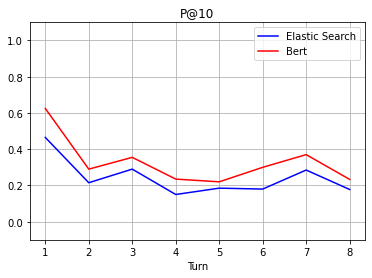

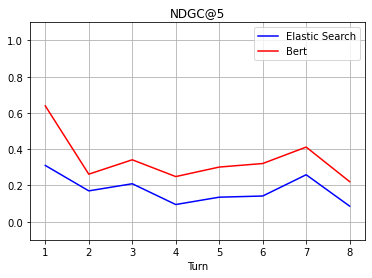

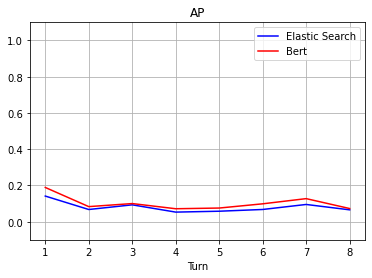

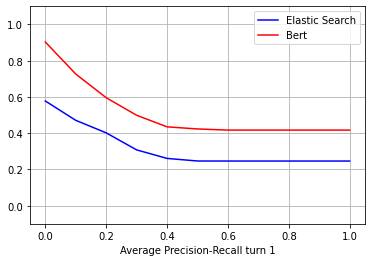

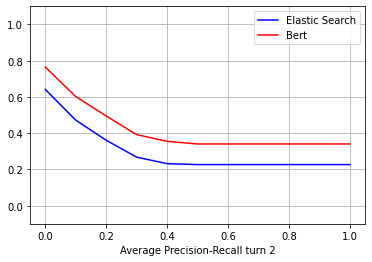

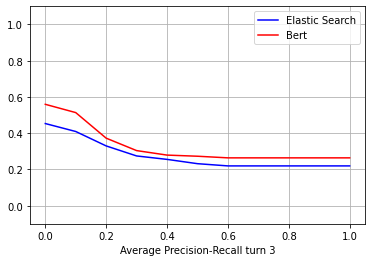

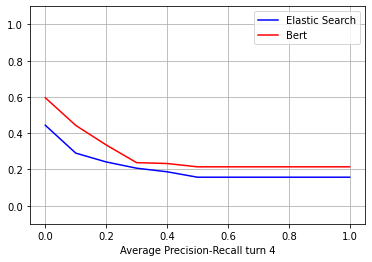

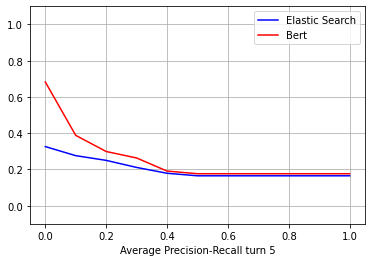

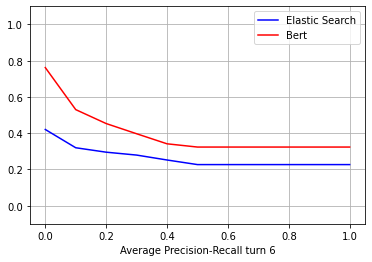

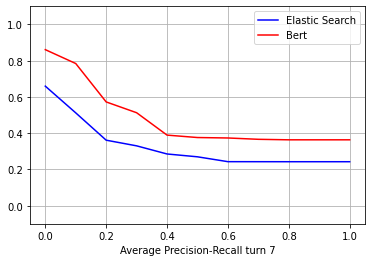

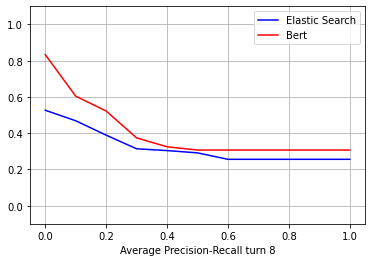

LMD
P10= 0.23895348837209304   Recall= 0.16716739361136979   NDCG@5 0.18025607112012662   AP 0.07942148266004084
BERT
P10= 0.3238372093023256   Recall= 0.16716739361136979   NDCG@5 0.3380212731401315   AP 0.10125383638577189


In [ ]:
_recall = 0
_p10 = 0
_ndcg5 = 0
_ap = 0
_nturns = 0
_recall_bert = 0
_p10_bert = 0
_ndcg5_bert = 0
_ap_bert = 0
_nturns_bert = 0
graphics = Graphics()
for topic in test_bed.test_topics:
    
    conv_id = topic['number']
    
   
    graphics.add_topic(conv_id)
    
    if conv_id not in (31, 32, 33, 34, 37, 40, 49, 50, 54, 56, 58, 59, 61, 67, 68, 69, 75, 77, 78, 79):
        continue

    for turn in topic['turn']:
        turn_id = turn['number']
        utterance = turn['raw_utterance']
        topic_turn_id = '%d_%d'% (conv_id, turn_id)
        turn_desc = '{} {}'.format(topic_turn_id, utterance)
        graphics.add_turn(conv_id, turn_desc)
        aux = test_bed.test_relevance_judgments.loc[test_bed.test_relevance_judgments['topic_turn_id'] == (topic_turn_id)]
        num_rel = aux.loc[aux['rel'] != 0]['docid'].count()
        
        if num_rel == 0:
            continue

        
        result = elastic.search_body(query=utterance, numDocs = 100)
        if np.size(result) == 0 or num_rel == 0:
            #print(topic_turn_id, utterance, num_rel, "NO RESULTS")
            continue
        #else:
         #   print(topic_turn_id, utterance, num_rel)

        [p10, recall, ap, ndcg5], precision_var, recall_var = test_bed.eval(result[['_id','_score']], topic_turn_id)

        algorithm = 'Elastic Search'
        
        graphics.add_p10(p10, conv_id, algorithm)
        graphics.add_ap(ap, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5, conv_id, algorithm)
        graphics.add_recall_var(recall_var, conv_id, algorithm)
        graphics.add_precision_var(precision_var, conv_id, algorithm)

#        print('P10=', p10, '  Recall=', recall, '  NDCG=',ndcg)
        _recall = _recall + recall
        _p10 = _p10 + p10
        _ndcg5 = _ndcg5 + ndcg5
        _ap = _ap + ap
        _nturns = _nturns + 1


        triplets = [] #(utterance, passagem, relevance judgment) tuples

        for index, row in result.iterrows():
          doc_body = row['_source.body']
          score = row['_score']
          triplets.append([utterance,doc_body, score])
        array = np.array(triplets)
        df_triplets = pd.DataFrame(data = array, columns = ['topic_turn', 'passage', 'rel'])
        #df_triplets

        sentences = df_triplets[['topic_turn', 'passage']]
        outputs = []
        for index, sentence in sentences.iterrows():
          inputs_qa = convert_to_bert_input(sentences=sentence, max_seq_length=512, tokenizer=tokenizer,add_cls=True)
          outputs_qa = model(**inputs_qa)
          print('-----------------------')

          outputs_qa = outputs_qa["last_hidden_state"][0,0].detach().clone()
          outputs.append(outputs_qa.numpy())
        
        preds = clf.predict_proba(outputs)
          
        preds = np.column_stack((result[['_id']],preds))
        
        preds= preds[np.lexsort((preds[:, 1], ))]
        
      
        df_triplets = pd.DataFrame(data = preds, columns = ['_id', 'prob_0', 'prob_1'])

        [p10_bert, recall_bert, ap_bert, ndcg5_bert], precision_var_bert, recall_var_bert = test_bed.eval(df_triplets[['_id','prob_1']], topic_turn_id)
 

        algorithm = 'Bert'
        graphics.add_p10(p10_bert, conv_id, algorithm)
        graphics.add_ap(ap_bert, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5_bert, conv_id, algorithm)
        graphics.add_recall_var(recall_var_bert, conv_id, algorithm)
        graphics.add_precision_var(precision_var_bert, conv_id, algorithm)

        _recall_bert = _recall_bert + recall_bert
        _p10_bert = _p10_bert + p10_bert
        _ndcg5_bert = _ndcg5_bert + ndcg5_bert
        _ap_bert = _ap_bert + +ap_bert
        _nturns_bert = _nturns_bert + 1
    graphics.plot_ap_per_topic(conv_id, 8)
    graphics.plot_p10_per_topic(conv_id, 8)
    graphics.plot_ndcg5_per_topic(conv_id, 8)
    graphics.plot_precision_recall_per_topic(conv_id,8)
    graphics.plot_precision_recall_per_topic_turn(conv_id,8)

graphics.plot_p10(8)
graphics.plot_ndcg5(8)
graphics.plot_ap(8)
graphics.plot_precision_recall_per_turn(8)


_p10 = _p10/_nturns
_recall = _recall/_nturns
_ndcg5 = _ndcg5/_nturns
_ap = _ap/_nturns
_p10_bert = _p10_bert/_nturns_bert
_recall_bert = _recall_bert/_nturns_bert
_ndcg5_bert = _ndcg5_bert/_nturns_bert
_ap_bert = _ap_bert/_nturns
print("LMD")
print('P10=', _p10, '  Recall=', _recall, '  NDCG@5', _ndcg5, '  AP', _ap, )
print("BERT")
print('P10=', _p10_bert, '  Recall=', _recall_bert, '  NDCG@5', _ndcg5_bert, '  AP', _ap_bert,)

Entidades

In [ ]:
_recall = 0
_p10 = 0
_ndcg5 = 0
_ap = 0
_nturns = 0
_recall_bert = 0
_p10_bert = 0
_ndcg5_bert = 0
_ap_bert = 0
_nturns_bert = 0
graphics = Graphics()
nlp = spacy.load('en_core_web_sm')
for topic in test_bed.test_topics:
    
    conv_id = topic['number']
    
   
    graphics.add_topic(conv_id)
    
    if conv_id not in (31, 32, 33, 34, 37, 40, 49, 50, 54, 56, 58, 59, 61, 67, 68, 69, 75, 77, 78, 79):
        continue
    entities_list = []
    boost_list = []
    for e in nlp(topic['turn'][0]['raw_utterance']).ents:
            entities_list.append(e.text)
            boost_list.append(1.0)
    for turn in topic['turn']:
        turn_id = turn['number']
        utterance = turn['raw_utterance']
        topic_turn_id = '%d_%d'% (conv_id, turn_id)
        turn_desc = '{} {}'.format(topic_turn_id, utterance)
        graphics.add_turn(conv_id, turn_desc)
        aux = test_bed.test_relevance_judgments.loc[test_bed.test_relevance_judgments['topic_turn_id'] == (topic_turn_id)]
        num_rel = aux.loc[aux['rel'] != 0]['docid'].count()
        
        if num_rel == 0:
            continue
      
        result = elastic.search_with_boosted_entities(utterance, entities_list, boost_list, numDocs=100)
        
        if np.size(result) == 0 or num_rel == 0:
            #print(topic_turn_id, utterance, num_rel, "NO RESULTS")
            continue
        #else:
         #   print(topic_turn_id, utterance, num_rel)

        [p10, recall, ap, ndcg5], precision_var, recall_var  = test_bed.eval(result[['_id','_score']], topic_turn_id)
  
        algorithm = 'Elastic Search'
        
        graphics.add_p10(p10, conv_id, algorithm)
        graphics.add_ap(ap, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5, conv_id, algorithm)
        graphics.add_recall_var(recall_var, conv_id, algorithm)
        graphics.add_precision_var(precision_var, conv_id, algorithm)

#        print('P10=', p10, '  Recall=', recall, '  NDCG=',ndcg)
        _recall = _recall + recall
        _p10 = _p10 + p10
        _ndcg5 = _ndcg5 + ndcg5
        _ap = _ap + ap
        _nturns = _nturns + 1


        triplets = [] #(utterance, passagem, relevance judgment) tuples

        for index, row in result.iterrows():
          doc_body = row['_source.body']
          score = row['_score']
          triplets.append([utterance,doc_body, score])
        array = np.array(triplets)
        df_triplets = pd.DataFrame(data = array, columns = ['topic_turn', 'passage', 'rel'])
        #df_triplets

        sentences = df_triplets[['topic_turn', 'passage']]
        outputs = []
        for index, sentence in sentences.iterrows():
          inputs_qa = convert_to_bert_input(sentences=sentence, max_seq_length=512, tokenizer=tokenizer,add_cls=True)
          outputs_qa = model(**inputs_qa)
          print('-----------------------')

          outputs_qa = outputs_qa["last_hidden_state"][0,0].detach().clone()
          outputs.append(outputs_qa.numpy())
        
        preds = clf.predict_proba(outputs)
          
        preds = np.column_stack((result[['_id']],preds))
        
        preds= preds[np.lexsort((preds[:, 1], ))]
        
        df_triplets = pd.DataFrame(data = preds, columns = ['_id', 'prob_0', 'prob_1'])

        [p10_bert, recall_bert, ap_bert, ndcg5_bert], precision_var_bert, recall_var_bert = test_bed.eval(df_triplets[['_id','prob_1']], topic_turn_id)
 

        algorithm = 'Bert'
        graphics.add_p10(p10_bert, conv_id, algorithm)
        graphics.add_ap(ap_bert, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5_bert, conv_id, algorithm)
        graphics.add_recall_var(recall_var_bert, conv_id, algorithm)
        graphics.add_precision_var(precision_var_bert, conv_id, algorithm)

        _recall_bert = _recall_bert + recall_bert
        _p10_bert = _p10_bert + p10_bert
        _ndcg5_bert = _ndcg5_bert + ndcg5_bert
        _ap_bert = _ap_bert + +ap_bert
        _nturns_bert = _nturns_bert + 1
    graphics.plot_ap_per_topic(conv_id, 8)
    graphics.plot_p10_per_topic(conv_id, 8)
    graphics.plot_ndcg5_per_topic(conv_id, 8)
    graphics.plot_precision_recall_per_topic(conv_id,8)
    graphics.plot_precision_recall_per_topic_turn(conv_id,8)

graphics.plot_p10(8)
graphics.plot_ndcg5(8)
graphics.plot_ap(8)
graphics.plot_precision_recall_per_turn(8)


_p10 = _p10/_nturns
_recall = _recall/_nturns
_ndcg5 = _ndcg5/_nturns
_ap = _ap/_nturns
_p10_bert = _p10_bert/_nturns_bert
_recall_bert = _recall_bert/_nturns_bert
_ndcg5_bert = _ndcg5_bert/_nturns_bert
_ap_bert = _ap_bert/_nturns
print("LMD")
print('P10=', _p10, '  Recall=', _recall, '  NDCG@5', _ndcg5, '  AP', _ap, )
print("BERT")
print('P10=', _p10_bert, '  Recall=', _recall_bert, '  NDCG@5', _ndcg5_bert, '  AP', _ap_bert,)

Output hidden; open in https://colab.research.google.com to view.

Uterâncias + 1

In [ ]:
_recall = 0
_p10 = 0
_ndcg5 = 0
_ap = 0
_nturns = 0
_recall_bert = 0
_p10_bert = 0
_ndcg5_bert = 0
_ap_bert = 0
_nturns_bert = 0
graphics = Graphics()
for topic in test_bed.test_topics:
    
    conv_id = topic['number']
    
   
    graphics.add_topic(conv_id)
    
    if conv_id not in (31, 32, 33, 34, 37, 40, 49, 50, 54, 56, 58, 59, 61, 67, 68, 69, 75, 77, 78, 79):
        continue
  
    for turn in topic['turn']:
        turn_id = turn['number']
        utterance = turn['raw_utterance']
        topic_turn_id = '%d_%d'% (conv_id, turn_id)
        turn_desc = '{} {}'.format(topic_turn_id, utterance)
        graphics.add_turn(conv_id, turn_desc)
        aux = test_bed.test_relevance_judgments.loc[test_bed.test_relevance_judgments['topic_turn_id'] == (topic_turn_id)]
        num_rel = aux.loc[aux['rel'] != 0]['docid'].count()
        
        if num_rel == 0:
            continue

        
        result = elastic.search_body(query=utterances_joined_1_test[conv_id][turn_id-1], numDocs = 100)
        if np.size(result) == 0 or num_rel == 0:
            #print(topic_turn_id, utterance, num_rel, "NO RESULTS")
            continue
        #else:
         #   print(topic_turn_id, utterance, num_rel)

        [p10, recall, ap, ndcg5], precision_var, recall_var = test_bed.eval(result[['_id','_score']], topic_turn_id)

        algorithm = 'Elastic Search'
        
        graphics.add_p10(p10, conv_id, algorithm)
        graphics.add_ap(ap, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5, conv_id, algorithm)
        graphics.add_recall_var(recall_var, conv_id, algorithm)
        graphics.add_precision_var(precision_var, conv_id, algorithm)

#        print('P10=', p10, '  Recall=', recall, '  NDCG=',ndcg)
        _recall = _recall + recall
        _p10 = _p10 + p10
        _ndcg5 = _ndcg5 + ndcg5
        _ap = _ap + ap
        _nturns = _nturns + 1


        triplets = [] #(utterance, passagem, relevance judgment) tuples

        for index, row in result.iterrows():
          doc_body = row['_source.body']
          score = row['_score']
          triplets.append([utterances_joined_1_test[conv_id][turn_id-1],doc_body, score])
        array = np.array(triplets)
        df_triplets = pd.DataFrame(data = array, columns = ['topic_turn', 'passage', 'rel'])
        #df_triplets

        sentences = df_triplets[['topic_turn', 'passage']]
        outputs = []
        for index, sentence in sentences.iterrows():
          inputs_qa = convert_to_bert_input(sentences=sentence, max_seq_length=512, tokenizer=tokenizer,add_cls=True)
          outputs_qa = model(**inputs_qa)
          print('-----------------------')

          outputs_qa = outputs_qa["last_hidden_state"][0,0].detach().clone()
          outputs.append(outputs_qa.numpy())
        
        preds = clf.predict_proba(outputs)
          
        preds = np.column_stack((result[['_id']],preds))
        
        preds= preds[np.lexsort((preds[:, 1], ))]
        
      
        df_triplets = pd.DataFrame(data = preds, columns = ['_id', 'prob_0', 'prob_1'])

        [p10_bert, recall_bert, ap_bert, ndcg5_bert], precision_var_bert, recall_var_bert = test_bed.eval(df_triplets[['_id','prob_1']], topic_turn_id)
 

        algorithm = 'Bert'
        graphics.add_p10(p10_bert, conv_id, algorithm)
        graphics.add_ap(ap_bert, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5_bert, conv_id, algorithm)
        graphics.add_recall_var(recall_var_bert, conv_id, algorithm)
        graphics.add_precision_var(precision_var_bert, conv_id, algorithm)

        _recall_bert = _recall_bert + recall_bert
        _p10_bert = _p10_bert + p10_bert
        _ndcg5_bert = _ndcg5_bert + ndcg5_bert
        _ap_bert = _ap_bert + +ap_bert
        _nturns_bert = _nturns_bert + 1
    graphics.plot_ap_per_topic(conv_id, 8)
    graphics.plot_p10_per_topic(conv_id, 8)
    graphics.plot_ndcg5_per_topic(conv_id, 8)
    graphics.plot_precision_recall_per_topic(conv_id,8)
    graphics.plot_precision_recall_per_topic_turn(conv_id,8)

graphics.plot_p10(8)
graphics.plot_ndcg5(8)
graphics.plot_ap(8)
graphics.plot_precision_recall_per_turn(8)


_p10 = _p10/_nturns
_recall = _recall/_nturns
_ndcg5 = _ndcg5/_nturns
_ap = _ap/_nturns
_p10_bert = _p10_bert/_nturns_bert
_recall_bert = _recall_bert/_nturns_bert
_ndcg5_bert = _ndcg5_bert/_nturns_bert
_ap_bert = _ap_bert/_nturns
print("LMD")
print('P10=', _p10, '  Recall=', _recall, '  NDCG@5', _ndcg5, '  AP', _ap, )
print("BERT")
print('P10=', _p10_bert, '  Recall=', _recall_bert, '  NDCG@5', _ndcg5_bert, '  AP', _ap_bert,)

Output hidden; open in https://colab.research.google.com to view.

Query Rewritting

In [ ]:
_recall = 0
_p10 = 0
_ndcg5 = 0
_ap = 0
_nturns = 0
_recall_bert = 0
_p10_bert = 0
_ndcg5_bert = 0
_ap_bert = 0
_nturns_bert = 0
graphics = Graphics()
for topic in test_bed.test_topics:
    
    conv_id = topic['number']
    
   
    graphics.add_topic(conv_id)
    
    if conv_id not in (31, 32, 33, 34, 37, 40, 49, 50, 54, 56, 58, 59, 61, 67, 68, 69, 75, 77, 78, 79):
        continue

    for turn in topic['turn']:
        turn_id = turn['number']
        utterance = turn['raw_utterance']
        topic_turn_id = '%d_%d'% (conv_id, turn_id)
        turn_desc = '{} {}'.format(topic_turn_id, utterance)
        graphics.add_turn(conv_id, turn_desc)
        aux = test_bed.test_relevance_judgments.loc[test_bed.test_relevance_judgments['topic_turn_id'] == (topic_turn_id)]
        num_rel = aux.loc[aux['rel'] != 0]['docid'].count()
        
        if num_rel == 0:
            continue

        
        result = elastic.search_body(query=utterances_entities_t5_test[conv_id][turn_id-1], numDocs = 100)
        if np.size(result) == 0 or num_rel == 0:
            #print(topic_turn_id, utterance, num_rel, "NO RESULTS")
            continue
        #else:
         #   print(topic_turn_id, utterance, num_rel)

        [p10, recall, ap, ndcg5], precision_var, recall_var = test_bed.eval(result[['_id','_score']], topic_turn_id)

        algorithm = 'Elastic Search'
        
        graphics.add_p10(p10, conv_id, algorithm)
        graphics.add_ap(ap, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5, conv_id, algorithm)
        graphics.add_recall_var(recall_var, conv_id, algorithm)
        graphics.add_precision_var(precision_var, conv_id, algorithm)

#        print('P10=', p10, '  Recall=', recall, '  NDCG=',ndcg)
        _recall = _recall + recall
        _p10 = _p10 + p10
        _ndcg5 = _ndcg5 + ndcg5
        _ap = _ap + ap
        _nturns = _nturns + 1


        triplets = [] #(utterance, passagem, relevance judgment) tuples

        for index, row in result.iterrows():
          doc_body = row['_source.body']
          score = row['_score']
          triplets.append([utterances_entities_t5_test[conv_id][turn_id-1],doc_body, score])
        array = np.array(triplets)
        df_triplets = pd.DataFrame(data = array, columns = ['topic_turn', 'passage', 'rel'])
        #df_triplets

        sentences = df_triplets[['topic_turn', 'passage']]
        outputs = []
        for index, sentence in sentences.iterrows():
          inputs_qa = convert_to_bert_input(sentences=sentence, max_seq_length=512, tokenizer=tokenizer,add_cls=True)
          outputs_qa = model(**inputs_qa)
          print('-----------------------')

          outputs_qa = outputs_qa["last_hidden_state"][0,0].detach().clone()
          outputs.append(outputs_qa.numpy())
        
        preds = clf.predict_proba(outputs)
          
        preds = np.column_stack((result[['_id']],preds))
        
        preds= preds[np.lexsort((preds[:, 1], ))]
        
      
        df_triplets = pd.DataFrame(data = preds, columns = ['_id', 'prob_0', 'prob_1'])

        [p10_bert, recall_bert, ap_bert, ndcg5_bert], precision_var_bert, recall_var_bert = test_bed.eval(df_triplets[['_id','prob_1']], topic_turn_id)
 

        algorithm = 'Bert'
        graphics.add_p10(p10_bert, conv_id, algorithm)
        graphics.add_ap(ap_bert, conv_id, algorithm)
        graphics.add_ndcg5(ndcg5_bert, conv_id, algorithm)
        graphics.add_recall_var(recall_var_bert, conv_id, algorithm)
        graphics.add_precision_var(precision_var_bert, conv_id, algorithm)

        _recall_bert = _recall_bert + recall_bert
        _p10_bert = _p10_bert + p10_bert
        _ndcg5_bert = _ndcg5_bert + ndcg5_bert
        _ap_bert = _ap_bert + +ap_bert
        _nturns_bert = _nturns_bert + 1
    graphics.plot_ap_per_topic(conv_id, 8)
    graphics.plot_p10_per_topic(conv_id, 8)
    graphics.plot_ndcg5_per_topic(conv_id, 8)
    graphics.plot_precision_recall_per_topic(conv_id,8)
    graphics.plot_precision_recall_per_topic_turn(conv_id,8)

graphics.plot_p10(8)
graphics.plot_ndcg5(8)
graphics.plot_ap(8)
graphics.plot_precision_recall_per_turn(8)


_p10 = _p10/_nturns
_recall = _recall/_nturns
_ndcg5 = _ndcg5/_nturns
_ap = _ap/_nturns
_p10_bert = _p10_bert/_nturns_bert
_recall_bert = _recall_bert/_nturns_bert
_ndcg5_bert = _ndcg5_bert/_nturns_bert
_ap_bert = _ap_bert/_nturns
print("LMD")
print('P10=', _p10, '  Recall=', _recall, '  NDCG@5', _ndcg5, '  AP', _ap, )
print("BERT")
print('P10=', _p10_bert, '  Recall=', _recall_bert, '  NDCG@5', _ndcg5_bert, '  AP', _ap_bert,)

Output hidden; open in https://colab.research.google.com to view.

# Gráficos


In [ ]:
import matplotlib.pyplot as plt


class Graphics:
  class Topic:
    def __init__(self, desc):
      self.id = desc
      self.turn_desc = []
      self.p10_lmd = []
      self.p10_bert = []
      self.ndcg5_lmd = []
      self.ndcg5_bert = []
      self.ap_lmd = []
      self.ap_bert = []
      self.recall_var_lmd = []
      self.recall_var_bert = []
      self.precision_var_lmd = []
      self.precision_var_bert = []
  
  def __init__(self):
    self.topics = []

  def find_topic_name(self, topic_name):
    for i in range(0, len(self.topics)):
        if self.topics[i].id == topic_name:
            return self.topics[i]
    return None

  def add_topic(self, topic_name):
    topic = self.Topic(topic_name)
    self.topics.append(topic)

  def add_turn(self, topic_name, t_desc):
    topic = self.find_topic_name(topic_name)
    topic.turn_desc.append(t_desc)


  def add_p10(self, p10_parc, topic_name, algorithm):
    topic = self.find_topic_name(topic_name)
    if topic is None:
        topic = Topic(topic_name)
        self.topics.append(topic)
    if algorithm == 'Elastic Search':
        topic.p10_lmd.append(p10_parc)
    else:
        topic.p10_bert.append(p10_parc)

  def add_ap(self, ap_parc, topic_name, algorithm):
    topic = self.find_topic_name(topic_name)
    if topic is None:
        topic = Topic(topic_name)
        self.topics.append(topic)
    if algorithm == 'Elastic Search':
        topic.ap_lmd.append(ap_parc)
    else:
        topic.ap_bert.append(ap_parc)

  def add_ndcg5(self, ndcg5_parc, topic_name, algorithm):
    topic = self.find_topic_name(topic_name)
    if topic is None:
        topic = Topic(topic_name)
        self.topics.append(topic)
    if algorithm == 'Elastic Search':
        topic.ndcg5_lmd.append(ndcg5_parc)
    else:
        topic.ndcg5_bert.append(ndcg5_parc)


  def add_recall_var(self, recall_var, topic_name, algorithm):
    topic = self.find_topic_name(topic_name)

    if topic is None:
        topic = Topic(topic_name)
        self.topics.append(topic)
    if algorithm == 'Elastic Search':
        topic.recall_var_lmd.append(recall_var)
    else:
        topic.recall_var_bert.append(recall_var)


  def add_precision_var(self, precision_var, topic_name, algorithm):
      topic = self.find_topic_name(topic_name)

      if topic is None:
          topic = Topic(topic_name)
          self.topics.append(topic)
      if algorithm == 'Elastic Search':
          topic.precision_var_lmd.append(precision_var)
      else:
          topic.precision_var_bert.append(precision_var)      


  def plot_p10_per_topic(self,topic_name, n_turns):
      topic = self.find_topic_name(topic_name)
      
      turns = min(len(topic.p10_lmd), n_turns)
      turns = min(len(topic.p10_bert), turns)
      plt.figure(frameon=False)
      
      plt.plot(topic.p10_lmd[:turns], topic.turn_desc[:turns], 'x', color="blue", label='Elastic Search')
      plt.plot(topic.p10_bert[:turns], topic.turn_desc[:turns], 'x', color="red", label='Bert')
      plt.xlim([-0.1,1.1])
      plt.legend(loc="upper right")
      plt.xlabel("P@10 topic " + str(topic_name))
      plt.grid()
      plt.savefig("P@10 topic " + str(topic_name),  bbox_inches = 'tight')
      plt.show()
      plt.close()


  def plot_p10(self,n_turns):
      p10_lmd = 0
      p10_bert = 0
      turns = np.zeros(n_turns)
      for topic in self.topics:
          topic_p10s = np.zeros(n_turns)
          topic_p10s[:len(topic.p10_lmd)] = topic.p10_lmd[:n_turns]
          p10_lmd += topic_p10s
          topic_p10s[:len(topic.p10_bert)] = topic.p10_bert[:n_turns]
          p10_bert += topic_p10s
          turns[:len(topic.p10_lmd)] += 1

      p10_lmd = np.divide(p10_lmd, turns)
      p10_bert = np.divide(p10_bert, turns)
      plt.figure(frameon=False)
      plt.plot(range(1, n_turns+1), p10_lmd, color="blue", label = 'Elastic Search')
      plt.plot(range(1, n_turns+1), p10_bert, color="red", label = 'Bert')
      plt.legend(loc="upper right")
      plt.title("P@10")
      plt.ylim([-0.1,1.1])
      plt.xlabel("Turn")
      plt.grid()
      plt.savefig("P@10",  bbox_inches = 'tight')
      plt.show()
      plt.close()


  # plot ap

  def plot_ap_per_topic(self, topic_name, n_turns):
      topic = self.find_topic_name(topic_name)
      turns = min(len(topic.ap_lmd), n_turns)
      plt.figure(frameon=False)
      plt.plot(topic.ap_lmd[:turns], topic.turn_desc[:turns], 'x', color="blue", label='Elastic Search')
      plt.plot(topic.ap_bert[:turns], topic.turn_desc[:turns], 'x', color="red", label='Bert')
      plt.legend(loc="upper right")
      plt.xlim([-0.1,1.1])
      plt.xlabel("AP topic " + str(topic_name))
      plt.grid()
      plt.savefig("AP topic " + str(topic_name),  bbox_inches = 'tight')
      plt.show()
      plt.close()

  def plot_ap(self, n_turns):
      ap_lmd = 0
      ap_bert = 0
      turns = np.zeros(n_turns)
      for topic in self.topics:
          topic_aps = np.zeros(n_turns)
          topic_aps[:len(topic.ap_lmd)] = topic.ap_lmd[:n_turns]
          ap_lmd += topic_aps
          topic_aps[:len(topic.ap_bert)] = topic.ap_bert[:n_turns]
          ap_bert += topic_aps
          turns[:len(topic.ap_lmd)] += 1

      ap_lmd = np.divide(ap_lmd, turns)
      ap_bert = np.divide(ap_bert, turns)
      plt.figure(frameon=False)
      plt.plot(range(1, n_turns+1), ap_lmd, color="blue", label = 'Elastic Search')
      plt.plot(range(1, n_turns+1), ap_bert, color="red", label = 'Bert')
      plt.legend(loc="upper right")
      plt.xlabel("Turn")
      plt.ylim([-0.1,1.1])
      plt.title("AP")
      plt.grid()
      plt.savefig("AP",  bbox_inches = 'tight')
      plt.show()
      plt.close()


  # plot ndcg5

  def plot_ndcg5_per_topic(self, topic_name, n_turns):
      topic = self.find_topic_name(topic_name)
      turns = min(len(topic.ndcg5_lmd), n_turns)
      plt.figure(frameon=False)
      plt.plot(topic.ndcg5_lmd[:turns],topic.turn_desc[:turns],'x',  color="blue", label='Elastic Search')
      plt.plot(topic.ndcg5_bert[:turns],topic.turn_desc[:turns],'x',  color="red", label='Bert')
      #plt.xticks(np.arange(0, 1.2, 0.2))
      plt.xlim([-0.1,1.1])
      plt.legend(loc="upper right")
      plt.xlabel("NDGC@5 topic " + str(topic_name))
      plt.grid()
      plt.savefig("NDGC@5 topic " + str(topic_name),  bbox_inches = 'tight')
      plt.show()
      plt.close()

  def plot_ndcg5(self, n_turns):
      ndcg5_lmd = 0
      ndcg5_bert = 0
      turns = np.zeros(n_turns)
      for topic in self.topics:
          topic_ndcg5s = np.zeros(n_turns)
          topic_ndcg5s[:len(topic.ndcg5_lmd)] = topic.ndcg5_lmd[:n_turns]
          ndcg5_lmd += topic_ndcg5s
          topic_ndcg5s[:len(topic.ndcg5_bert)] = topic.ndcg5_bert[:n_turns]
          ndcg5_bert += topic_ndcg5s
          turns[:len(topic.ndcg5_lmd)] += 1

      ndcg5_lmd = np.divide(ndcg5_lmd, turns)
      ndcg5_bert = np.divide(ndcg5_bert, turns)
      plt.figure(frameon=False)
      plt.plot(range(1, n_turns+1), ndcg5_lmd, color="blue", label = 'Elastic Search')
      plt.plot(range(1, n_turns+1), ndcg5_bert, color="red", label = 'Bert')
      plt.legend(loc="upper right")
      plt.xlabel("Turn")
      plt.title("NDGC@5")
      plt.ylim([-0.1,1.1])
      plt.grid()
      plt.savefig("NDGC@5",  bbox_inches = 'tight')
      plt.show()
      plt.close()
      


  #plot pr

  def plot_precision_recall_per_topic(self, topic_name, n_turns):
      recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
      count = np.zeros(len(recall_11point))
      precision_11point_lmd = np.zeros(len(recall_11point))
      precision_11point_bert = np.zeros(len(recall_11point))
      topic = self.find_topic_name(topic_name)
      if len(topic.recall_var_lmd):
          for i in range(min(len(topic.recall_var_lmd), n_turns)):
              if len(topic.recall_var_lmd[i]):
                  precision_11point_lmd_ = np.interp(recall_11point, topic.recall_var_lmd[i], topic.precision_var_lmd[i])
                  precision_11point_bert_ = np.interp(recall_11point, topic.recall_var_bert[i], topic.precision_var_bert[i])
                  precision_11point_lmd =  np.add(precision_11point_lmd, precision_11point_lmd_)
                  precision_11point_bert = np.add(precision_11point_bert, precision_11point_bert_)
                  count = np.add(count, np.ones(len(recall_11point)))
      precision_11point_lmd = np.divide(precision_11point_lmd , count)
      precision_11point_bert = np.divide(precision_11point_bert , count)


      plt.figure(frameon=False)
      plt.plot(recall_11point, np.flip(np.maximum.accumulate(np.flip(precision_11point_lmd))), color='blue', label='Elastic Search')
      plt.plot(recall_11point, np.flip(np.maximum.accumulate(np.flip(precision_11point_bert))), color='red', label='Bert')
      plt.legend(loc="upper right")
      plt.xlabel("Precision-Recall topic " + str(topic_name))
      plt.grid()
      plt.ylim([-0.1,1.1])
      plt.savefig("Precision-Recall topic " + str(topic_name),  bbox_inches = 'tight')
      plt.show()
      plt.close()


  def plot_precision_recall_per_topic_turn(self, topic_name, n_turns):
      recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
      precision_11point_lmd = np.zeros(len(recall_11point))
      precision_11point_bert = np.zeros(len(recall_11point))
      topic = self.find_topic_name(topic_name)
      if len(topic.recall_var_lmd):
          for i in range(min(len(topic.recall_var_lmd), n_turns)):
              if len(topic.recall_var_lmd[i]):
                  precision_11point_lmd = np.interp(recall_11point, topic.recall_var_lmd[i], topic.precision_var_lmd[i])
                  precision_11point_bert = np.interp(recall_11point, topic.recall_var_bert[i], topic.precision_var_bert[i])
                  plt.figure(frameon=False)
                  plt.plot(recall_11point, np.flip(np.maximum.accumulate(np.flip(precision_11point_lmd))), color="blue", label = 'Elastic Search')
                  plt.plot(recall_11point, np.flip(np.maximum.accumulate(np.flip(precision_11point_bert))), color="red", label = 'Bert')
                  plt.legend(loc="upper right")
                  plt.xlabel("Precision-Recall topic" + str(topic_name) + " turn " + str(i+1))
                  plt.grid()
                  plt.ylim([-0.1,1.1])
                  plt.savefig("Precision-Recall topic" + str(topic_name) + " turn " + str(i+1),  bbox_inches = 'tight')
                  plt.show()
                  plt.close()

  def plot_precision_recall_per_turn(self, n_turns):
      recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
      for i in range(n_turns):
          count = np.zeros(len(recall_11point))
          precision_11point_lmd = np.zeros(len(recall_11point))
          precision_11point_bert = np.zeros(len(recall_11point))
          for topic in self.topics:
              if i < len(topic.recall_var_lmd) and len(topic.recall_var_lmd[i]):
                  precision_11point_lmd = np.add(precision_11point_lmd , np.interp(recall_11point, topic.recall_var_lmd[i], topic.precision_var_lmd[i]))
                  precision_11point_bert = np.add(precision_11point_bert, np.interp(recall_11point, topic.recall_var_bert[i], topic.precision_var_bert[i]))
                  count = np.add(count, np.ones(len(recall_11point)))
          precision_11point_lmd = np.divide(precision_11point_lmd,count)
          precision_11point_bert = np.divide(precision_11point_bert , count)
          plt.figure(frameon=False)
          plt.plot(recall_11point, np.flip(np.maximum.accumulate(np.flip(precision_11point_lmd))), color='blue', label = 'Elastic Search')
          plt.plot(recall_11point, np.flip(np.maximum.accumulate(np.flip(precision_11point_bert))), color='red', label = 'Bert')
          plt.legend(loc="upper right")
          plt.xlabel("Average Precision-Recall turn " + str(i+1))
          plt.grid()
          plt.ylim([-0.1,1.1])
          plt.savefig("Average Precision-Recall turn " + str(i+1), bbox_inches = 'tight')
          plt.show()
          plt.close()